In [1]:

%pip install -q scipy scikit-learn



[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



# B2B Invoice Analysis & Correlations
Combined cleaning, descriptive analysis, correlation exploration, and modeling in one notebook.


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
sns.set(style="whitegrid")

df = pd.read_csv("dataset.csv", delimiter=";")
print(df.shape)
df.info()
df.head()


(50000, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              40000 non-null  object 
 4   buisness_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,200769623,WAL-MAR corp,2020-02-11 00:00,"2,020.0000","1,930,438,491.0000",2020-01-26,20200125,20200126,"20,200,210.0000",USD,RV,1.0000,NaN,"54,273.2800","20,200,126.0000",NAH4,"1,930,438,491.0000",0
1,U001,200980828,BEN E,2019-08-08 00:00,"2,019.0000","1,929,646,410.0000",2019-07-22,20190722,20190722,"20,190,811.0000",USD,RV,1.0000,NaN,"79,656.6000","20,190,722.0000",NAD1,"1,929,646,410.0000",0
2,U001,200792734,MDV/ trust,2019-12-30 00:00,"2,019.0000","1,929,873,765.0000",2019-09-14,20190914,20190914,"20,190,929.0000",USD,RV,1.0000,NaN,"2,253.8600","20,190,914.0000",NAA8,"1,929,873,765.0000",0
3,CA02,140105686,SYSC llc,NaN,"2,020.0000","2,960,623,488.0000",2020-03-30,20200330,20200330,"20,200,410.0000",CAD,RV,1.0000,NaN,"3,299.7000","20,200,331.0000",CA10,"2,960,623,488.0000",1
4,U001,200769623,WAL-MAR foundation,2019-11-25 00:00,"2,019.0000","1,930,147,974.0000",2019-11-13,20191113,20191113,"20,191,128.0000",USD,RV,1.0000,NaN,"33,133.2900","20,191,113.0000",NAH4,"1,930,147,974.0000",0


In [3]:

# Helper for dates in YYYYMMDD or YYYYMMDD.0 format
def fix_date(col):
    return (
        col.astype(str)
        .str.replace(".0", "", regex=False)
        .str.replace(".0", "", regex=False)
        .str.zfill(8)
        .pipe(pd.to_datetime, format="%Y%m%d", errors="coerce")
    )

raw_yyyymmdd_cols = [
    "document_create_date",
    "document_create_date.1",
    "due_in_date",
    "baseline_create_date",
]

for col in raw_yyyymmdd_cols:
    if col in df.columns:
        df[col] = fix_date(df[col])

for col in ["posting_date", "clear_date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

df[raw_yyyymmdd_cols + ["posting_date", "clear_date"]].head()


,document_create_date,document_create_date.1,due_in_date,baseline_create_date,posting_date,clear_date
0,2020-01-25,2020-01-26,2020-02-10,2020-01-26,2020-01-26,2020-02-11
1,2019-07-22,2019-07-22,2019-08-11,2019-07-22,2019-07-22,2019-08-08
2,2019-09-14,2019-09-14,2019-09-29,2019-09-14,2019-09-14,2019-12-30
3,2020-03-30,2020-03-30,2020-04-10,2020-03-31,2020-03-30,NaT
4,2019-11-13,2019-11-13,2019-11-28,2019-11-13,2019-11-13,2019-11-25


In [4]:

print(df["invoice_currency"].value_counts())
print("------------")
print(df["cust_payment_terms"].value_counts())
print("------------")
print(df.isna().mean().sort_values(ascending=False))


invoice_currency
USD    46081
CAD     3919
Name: count, dtype: int64
------------
cust_payment_terms
NAA8    20118
NAH4    13585
CA10     3800
NAC6     1743
NAM4     1385
        ...  
NATU        1
NAUY        1
C129        1
NATV        1
MC15        1
Name: count, Length: 74, dtype: int64
------------
area_business            1.0000
clear_date               0.2000
invoice_id               0.0001
business_code            0.0000
invoice_currency         0.0000
cust_payment_terms       0.0000
baseline_create_date     0.0000
total_open_amount        0.0000
posting_id               0.0000
document type            0.0000
due_in_date              0.0000
cust_number              0.0000
document_create_date.1   0.0000
document_create_date     0.0000
posting_date             0.0000
doc_id                   0.0000
buisness_year            0.0000
name_customer            0.0000
isOpen                   0.0000
dtype: float64


In [5]:

# Create synthetic customer IDs and clean names
unique_customers_number = df["cust_number"].unique()
unique_customers = sorted(unique_customers_number)

mapping = {cust: 100000 + i for i, cust in enumerate(unique_customers)}

df["customer_alt_id"] = df["cust_number"].map(mapping)

print(f"Unique numbers: {df['customer_alt_id'].nunique()}")
print(f"Unique names: {df['name_customer'].nunique()}")

# 1. Normalize names
df["name_normalized"] = (
    df["name_customer"]
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z0-9 ]", "", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# 2. Frequency per normalized name and alt id
name_counts = (
    df.groupby(["customer_alt_id", "name_normalized"])
    .size()
    .reset_index(name="count")
)

# 3. Pick the most frequent name per alt id
most_frequent_names = (
    name_counts
    .sort_values(["customer_alt_id", "count"], ascending=[True, False])
    .drop_duplicates(subset=["customer_alt_id"])
    .rename(columns={"name_normalized": "customer_clean_name"})
    .loc[:, ["customer_alt_id", "customer_clean_name"]]
)

# 4. Add clean name
df = df.merge(most_frequent_names, on="customer_alt_id", how="left")

# 5. Find clean names shared by multiple alt ids
name_counts_per_clean = most_frequent_names["customer_clean_name"].value_counts()
shared_names = name_counts_per_clean[name_counts_per_clean > 1].index

# 6. Build display name that is unique per alt id
def make_display_name(row):
    base = row["customer_clean_name"]
    if base in shared_names:
        return f"{base} {row['customer_alt_id']}"
    return base

most_frequent_names["customer_display_name"] = most_frequent_names.apply(
    make_display_name, axis=1
)

# 7. Add display name
df = df.merge(
    most_frequent_names[["customer_alt_id", "customer_display_name"]],
    on="customer_alt_id",
    how="left",
)

print("Examples of names shared across IDs:")
print(
    most_frequent_names[most_frequent_names["customer_clean_name"].isin(shared_names)].head(10)
)

print(f"Unique numbers: {df['customer_alt_id'].nunique()}")
print(f"Unique names: {df['customer_display_name'].nunique()}")

df.head(10)


Unique numbers: 1099
Unique names: 4197
Examples of names shared across IDs:
     customer_alt_id  customer_clean_name       customer_display_name
2             100001     gree corporation     gree corporation 100001
86            100028                unite                unite 100028
107           100033  sysco in foundation  sysco in foundation 100033
112           100034        so associates        so associates 100034
151           100048                us us                us us 100048
182           100059               dec co               dec co 100059
192           100062    perfor foundation    perfor foundation 100062
218           100068               perfor               perfor 100068
230           100073            perfor co            perfor co 100073
308           100095     sysc corporation     sysc corporation 100095
Unique numbers: 1099
Unique names: 1099


,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,customer_alt_id,name_normalized,customer_clean_name,customer_display_name
0,U001,200769623,WAL-MAR corp,2020-02-11,"2,020.0000","1,930,438,491.0000",2020-01-26,2020-01-25,2020-01-26,2020-02-10,...,NaN,"54,273.2800",2020-01-26,NAH4,"1,930,438,491.0000",0,100908,walmar corp,walmar trust,walmar trust
1,U001,200980828,BEN E,2019-08-08,"2,019.0000","1,929,646,410.0000",2019-07-22,2019-07-22,2019-07-22,2019-08-11,...,NaN,"79,656.6000",2019-07-22,NAD1,"1,929,646,410.0000",0,101072,ben e,ben e associates,ben e associates
2,U001,200792734,MDV/ trust,2019-12-30,"2,019.0000","1,929,873,765.0000",2019-09-14,2019-09-14,2019-09-14,2019-09-29,...,NaN,"2,253.8600",2019-09-14,NAA8,"1,929,873,765.0000",0,100977,mdv trust,mdv corporation,mdv corporation
3,CA02,140105686,SYSC llc,NaT,"2,020.0000","2,960,623,488.0000",2020-03-30,2020-03-30,2020-03-30,2020-04-10,...,NaN,"3,299.7000",2020-03-31,CA10,"2,960,623,488.0000",1,100435,sysc llc,sysc systems,sysc systems
4,U001,200769623,WAL-MAR foundation,2019-11-25,"2,019.0000","1,930,147,974.0000",2019-11-13,2019-11-13,2019-11-13,2019-11-28,...,NaN,"33,133.2900",2019-11-13,NAH4,"1,930,147,974.0000",0,100908,walmar foundation,walmar trust,walmar trust
5,CA02,140106181,THE corporation,2019-12-04,"2,019.0000","2,960,581,231.0000",2019-09-20,2019-09-20,2019-09-20,2019-10-04,...,NaN,"22,225.8400",2019-09-24,CA10,"2,960,581,231.0000",0,100447,the corporation,the corp,the corp 100447
6,U001,200769623,WAL-MAR in,2019-11-12,"2,019.0000","1,930,083,373.0000",2019-11-01,2019-10-31,2019-11-01,2019-11-16,...,NaN,"7,358.4900",2019-11-01,NAH4,"1,930,083,373.0000",0,100908,walmar in,walmar trust,walmar trust
7,U001,200744019,TARG us,NaT,"2,020.0000","1,930,659,387.0000",2020-03-19,2020-03-18,2020-03-19,2020-04-03,...,NaN,"11,173.0200",2020-03-19,NAA8,"1,930,659,387.0000",1,100852,targ us,targ systems,targ systems
8,U001,200769623,WAL-MAR corp,2019-06-18,"2,019.0000","1,929,439,637.0000",2019-06-07,2019-06-05,2019-06-07,2019-06-22,...,NaN,"15,995.0400",2019-06-07,NAH4,"1,929,439,637.0000",0,100908,walmar corp,walmar trust,walmar trust
9,U001,200762301,C&S WH systems,2019-03-06,"2,019.0000","1,928,819,386.0000",2019-02-20,2019-02-19,2019-02-20,2019-03-07,...,NaN,28.6300,2019-02-20,NAC6,"1,928,819,386.0000",0,100891,cs wh systems,cs wh systems,cs wh systems


In [6]:

# Basic features for open/closed invoices
closed_invoices = df[df["isOpen"] == 0].copy()
open_invoices = df[df["isOpen"] == 1].copy()

closed_invoices["days_to_due"] = (closed_invoices["due_in_date"] - closed_invoices["posting_date"]).dt.days
closed_invoices["days_to_clear"] = (closed_invoices["clear_date"] - closed_invoices["posting_date"]).dt.days
closed_invoices["delay_days"] = (closed_invoices["clear_date"] - closed_invoices["due_in_date"]).dt.days
closed_invoices["grace_period"] = (closed_invoices["due_in_date"] - closed_invoices["posting_date"]).dt.days
closed_invoices["amount"] = closed_invoices["total_open_amount"]

if "business_code" in closed_invoices.columns:
    closed_invoices["biz_CA02"] = (closed_invoices["business_code"] == "CA02").astype(int)
else:
    closed_invoices["biz_CA02"] = 0

def payment_status(delay):
    if pd.isna(delay):
        return "unknown"
    if delay < -1:
        return "early"
    elif -1 <= delay <= 1:
        return "on_time"
    return "late"

closed_invoices["payment_status"] = closed_invoices["delay_days"].apply(payment_status)
closed_invoices["is_late"] = (closed_invoices["payment_status"] == "late").astype(int)
closed_invoices["is_early"] = (closed_invoices["payment_status"] == "early").astype(int)

print(f"Share without clear_date among closed: {closed_invoices['clear_date'].isna().mean():.2%}")
closed_invoices[["delay_days", "payment_status", "is_late", "is_early"]].head()


Share without clear_date among closed: 0.00%


,delay_days,payment_status,is_late,is_early
0,1,on_time,0,0
1,-3,early,0,1
2,92,late,1,0
4,-3,early,0,1
5,61,late,1,0


payment_status
early      12178
on_time    15852
late       11970
Name: count, dtype: int64


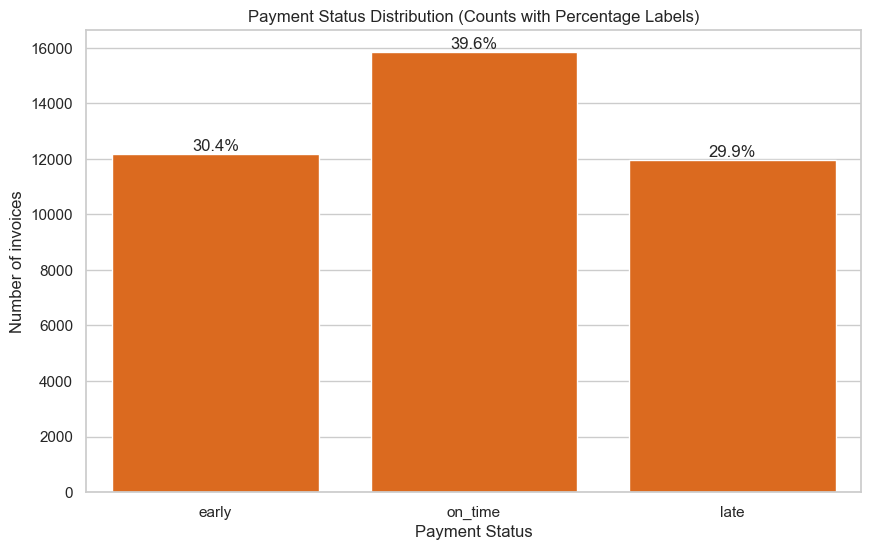

In [7]:

# Color palette used across charts
tr_orange = "#FA6400"
tr_green = "#123021"

order = ["early", "on_time", "late"]
status_counts = closed_invoices["payment_status"].value_counts().reindex(order)
status_pct = (status_counts / status_counts.sum() * 100).reindex(order)

print(status_counts)

plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=status_counts.index,
    y=status_counts.values,
    order=order,
    color=tr_orange,
)
plt.title("Payment Status Distribution (Counts with Percentage Labels)")
plt.ylabel("Number of invoices")
plt.xlabel("Payment Status")

for i, (pct, count) in enumerate(zip(status_pct.values, status_counts.values)):
    plt.text(i, count, f"{pct:.1f}%", ha='center', va='bottom', fontsize=12)

plt.show()


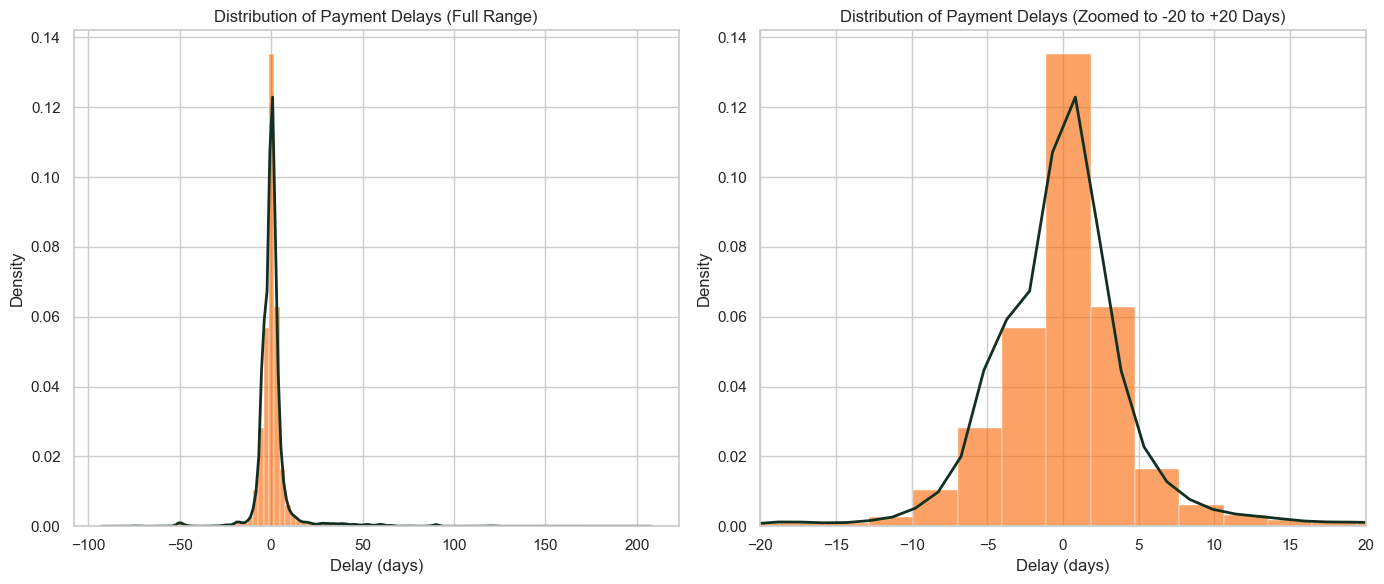

In [8]:

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.histplot(
    closed_invoices["delay_days"],
    bins=100,
    color=tr_orange,
    stat="density",
    alpha=0.6,
)
sns.kdeplot(
    closed_invoices["delay_days"],
    color=tr_green,
    linewidth=2,
)
plt.title("Distribution of Payment Delays (Full Range)")
plt.xlabel("Delay (days)")
plt.ylabel("Density")

plt.subplot(1, 2, 2)
sns.histplot(
    closed_invoices["delay_days"],
    bins=100,
    color=tr_orange,
    stat="density",
    alpha=0.6,
)
sns.kdeplot(
    closed_invoices["delay_days"],
    color=tr_green,
    linewidth=2,
)
plt.xlim(-20, 20)
plt.title("Distribution of Payment Delays (Zoomed to -20 to +20 Days)")
plt.xlabel("Delay (days)")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


In [23]:

# Late payment costs
closed_invoices["late_days"] = closed_invoices["delay_days"].clip(lower=0)
late_mask = closed_invoices["late_days"] > 0

annual_rate = 0.10
daily_rate = annual_rate / 365

closed_invoices["late_cost"] = (
    closed_invoices["total_open_amount"] * daily_rate * closed_invoices["late_days"]
)

late_costs = closed_invoices.loc[late_mask, "late_cost"]

print(f"Total invoice amount of late payments: ${closed_invoices.loc[late_mask, 'total_open_amount'].sum():,.2f}")
print(f"Total cost of late payments (interest-based): ${late_costs.sum():,.2f}")
print(f"Median cost per late invoice: ${late_costs.median():,.2f}")
print(f"Average cost per late invoice: ${late_costs.mean():,.2f}")

percentiles = late_costs.quantile([0.50, 0.75, 0.90, 0.95])
print("Percentiles (cost per late invoice):")
for pct, value in percentiles.items():
    print(f"P{int(pct*100):>2}: ${value:,.2f}")


Total invoice amount of late payments: $571,720,594.44
Total cost of late payments (interest-based): $782,159.60
Median cost per late invoice: $13.94
Average cost per late invoice: $46.66
Percentiles (cost per late invoice):
P50: $13.94
P75: $40.44
P90: $106.43
P95: $193.01


In [22]:
# Late days summary
mean_late_days = closed_invoices.loc[late_mask, "late_days"].median()
avg_late_days_all = closed_invoices.loc[late_mask, "late_days"].mean()
print(f"Median late days (late invoices only): {mean_late_days:.2f}")
print(f"Average late days (late invoices only): {avg_late_days_all:.2f}")


Median late days (late invoices only): 2.00
Average late days (late invoices only): 6.46


In [11]:

# Daily and monthly late-cost aggregation
late_invoices = closed_invoices[late_mask].copy()

daily_rows = []
for _, row in late_invoices.iterrows():
    start = row["due_in_date"] + pd.Timedelta(days=1)
    end = row["clear_date"]
    if pd.isna(start) or pd.isna(end) or end < start:
        continue
    days = pd.date_range(start, end)
    daily_rows.append(
        pd.DataFrame({
            "date": days,
            "customer_alt_id": row["customer_alt_id"],
            "customer_display_name": row["customer_display_name"],
            "amount_late": row["total_open_amount"],
        })
    )

daily_cost_df = pd.concat(daily_rows, ignore_index=True)
daily_cost_df["daily_cost"] = daily_cost_df["amount_late"] * daily_rate

daily_total_cost = (
    daily_cost_df
    .groupby("date")["daily_cost"]
    .sum()
    .reset_index()
)

daily_total_cost["month"] = daily_total_cost["date"].dt.to_period("M")

monthly_cost = (
    daily_total_cost
    .groupby("month")["daily_cost"]
    .sum()
    .reset_index()
    .rename(columns={"daily_cost": "monthly_cost"})
)

closed_invoices["month"] = closed_invoices["clear_date"].dt.to_period("M")
monthly_invoice_count = (
    closed_invoices[late_mask]
    .groupby("month")["invoice_id"]
    .nunique()
    .reset_index(name="late_invoice_count")
)

monthly_summary = monthly_cost.merge(
    monthly_invoice_count,
    on="month",
    how="left"
)
monthly_summary["late_invoice_count"] = monthly_summary["late_invoice_count"].fillna(0).astype(int)

display(daily_total_cost.head())
display(monthly_summary.head())


,date,daily_cost,month
0,2018-12-25,42.4687,2018-12
1,2018-12-26,42.4687,2018-12
2,2018-12-27,42.4687,2018-12
3,2018-12-28,42.4687,2018-12
4,2018-12-29,42.4687,2018-12


,month,monthly_cost,late_invoice_count
0,2018-12,297.6384,0
1,2019-01,"18,323.3019",472
2,2019-02,"47,657.4723",983
3,2019-03,"57,630.4800",1216
4,2019-04,"60,322.1883",1266


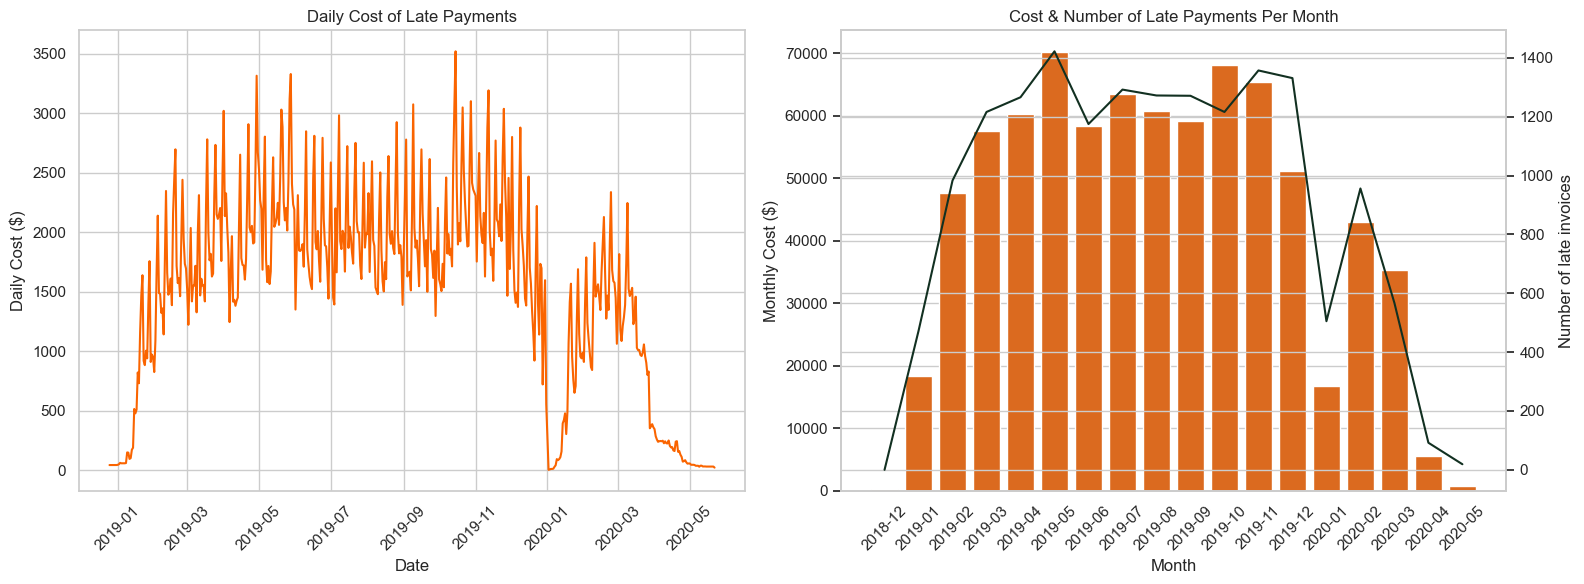

In [12]:

import matplotlib.ticker as mtick

fig, axes = plt.subplots(1, 2, figsize=(16,6))

sns.lineplot(
    data=daily_total_cost,
    x="date",
    y="daily_cost",
    ax=axes[0],
    color=tr_orange,
)
axes[0].set_title("Daily Cost of Late Payments")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Daily Cost ($)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].ticklabel_format(style='plain', axis='y')

monthly_summary_plot = monthly_summary.copy()
monthly_summary_plot["month_str"] = monthly_summary_plot["month"].astype(str)

ax1 = axes[1]
sns.barplot(
    data=monthly_summary_plot,
    x="month_str",
    y="monthly_cost",
    ax=ax1,
    color=tr_orange,
)
ax1.set_title("Cost & Number of Late Payments Per Month")
ax1.set_xlabel("Month")
ax1.set_ylabel("Monthly Cost ($)")
ax1.tick_params(axis='x', rotation=45)
ax1.ticklabel_format(style='plain', axis='y')

ax2 = ax1.twinx()
sns.lineplot(
    data=monthly_summary_plot,
    x="month_str",
    y="late_invoice_count",
    ax=ax2,
    color=tr_green,
    marker=None,
)
ax2.set_ylabel("Number of late invoices")
ax2.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()


In [13]:

# Customer-level costs and late behavior
customer_delay_stats = (
    closed_invoices
    .groupby(["customer_alt_id", "customer_display_name"])
    .agg(
        n_invoices=("invoice_id", "count"),
        late_invoices=("late_days", lambda x: (x > 0).sum()),
        total_late_days=("late_days", "sum"),
        med_late_days=("late_days", "median"),
    )
)
customer_delay_stats["pct_late_invoices"] = (
    customer_delay_stats["late_invoices"] / customer_delay_stats["n_invoices"] * 100
).round(2)
customer_delay_stats = customer_delay_stats.sort_values("total_late_days", ascending=False)

customer_cost_stats = (
    closed_invoices
    .groupby(["customer_alt_id", "customer_display_name"])
    .agg(
        n_invoices=("invoice_id", "count"),
        late_invoices=("late_days", lambda x: (x > 0).sum()),
        total_late_days=("late_days", "sum"),
        total_late_cost=("late_cost", "sum"),
        avg_late_cost=("late_cost", "mean"),
        total_invoice_amount=("total_open_amount", "sum"),
    )
    .sort_values("total_late_cost", ascending=False)
    .reset_index()
)

customer_monthly_cost = (
    closed_invoices
    .groupby(["customer_alt_id", "customer_display_name", "month"])
    .agg(monthly_late_cost=("late_cost", "sum"))
    .reset_index()
)

avg_monthly = (
    customer_monthly_cost
    .groupby(["customer_alt_id", "customer_display_name"])
    .agg(months_active=("month", "nunique"), avg_monthly_late_cost=("monthly_late_cost", "mean"))
    .reset_index()
)

customer_cost_stats = customer_cost_stats.merge(
    avg_monthly,
    on=["customer_alt_id", "customer_display_name"],
    how="left",
)

customer_cost_stats["pct_late_invoices"] = (
    customer_cost_stats["late_invoices"] / customer_cost_stats["n_invoices"] * 100
)

customer_cost_stats.head(10)

top10_total = customer_cost_stats.head(10)
top10_monthly = customer_cost_stats.sort_values(
    "avg_monthly_late_cost", ascending=False
).head(10)


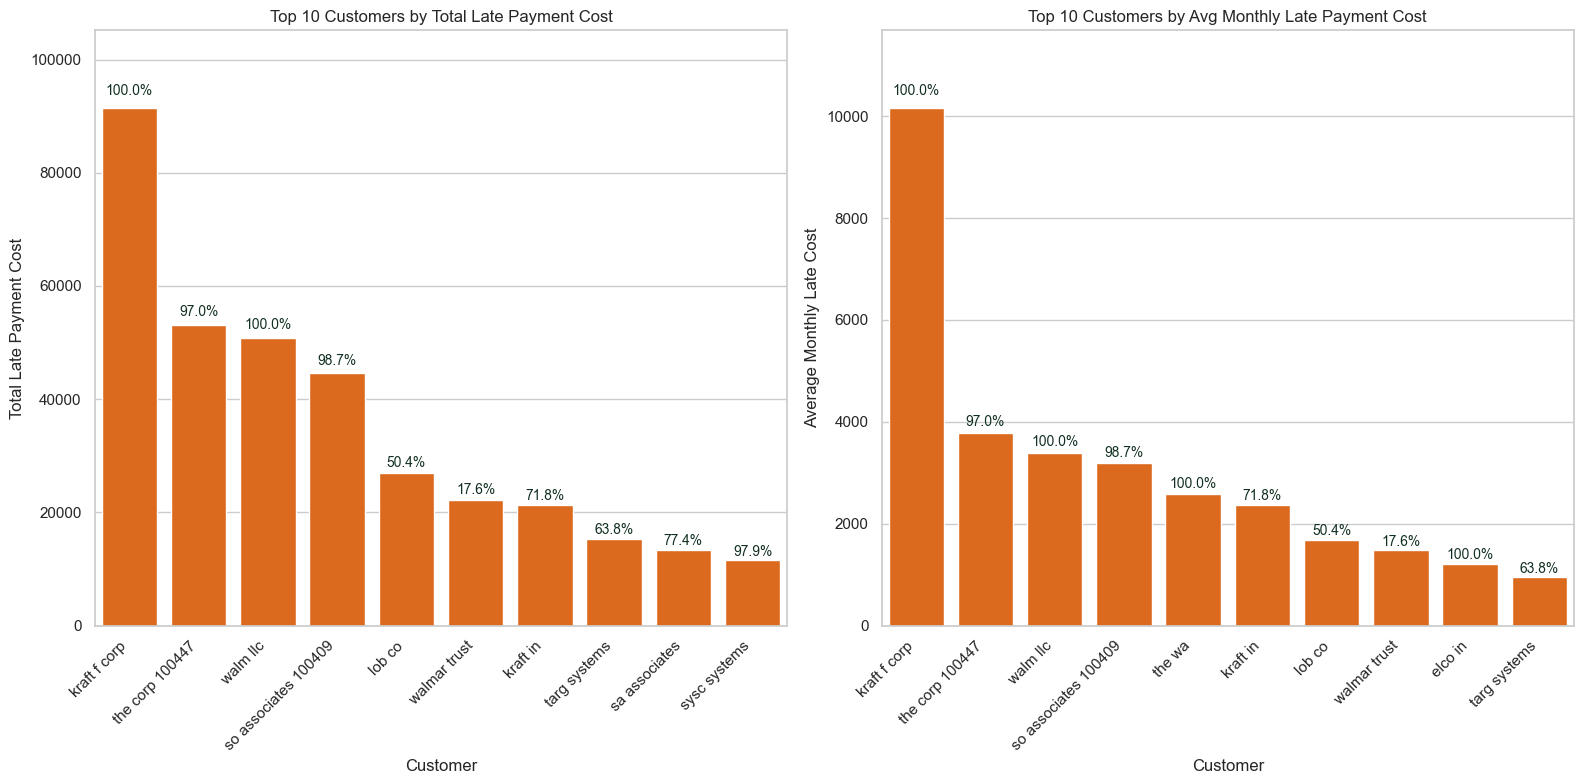

In [14]:

plt.figure(figsize=(16,8))

ax1 = plt.subplot(1, 2, 1)
sns.barplot(
    data=top10_total,
    x="customer_display_name",
    y="total_late_cost",
    color=tr_orange,
)
plt.title("Top 10 Customers by Total Late Payment Cost")
plt.ylabel("Total Late Payment Cost")
plt.xlabel("Customer")
plt.xticks(rotation=45, ha="right")
ax1.set_ylim(0, top10_total["total_late_cost"].max() * 1.15)
for bar, pct in zip(ax1.patches, top10_total["pct_late_invoices"]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax1.text(x, y * 1.02, f"{pct:.1f}%", ha="center", va="bottom", fontsize=10, color=tr_green)

ax2 = plt.subplot(1, 2, 2)
sns.barplot(
    data=top10_monthly,
    x="customer_display_name",
    y="avg_monthly_late_cost",
    color=tr_orange,
)
plt.title("Top 10 Customers by Avg Monthly Late Payment Cost")
plt.ylabel("Average Monthly Late Cost")
plt.xlabel("Customer")
plt.xticks(rotation=45, ha="right")
ax2.set_ylim(0, top10_monthly["avg_monthly_late_cost"].max() * 1.15)
for bar, pct in zip(ax2.patches, top10_monthly["pct_late_invoices"]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax2.text(x, y * 1.02, f"{pct:.1f}%", ha="center", va="bottom", fontsize=10, color=tr_green)

plt.tight_layout()
plt.show()


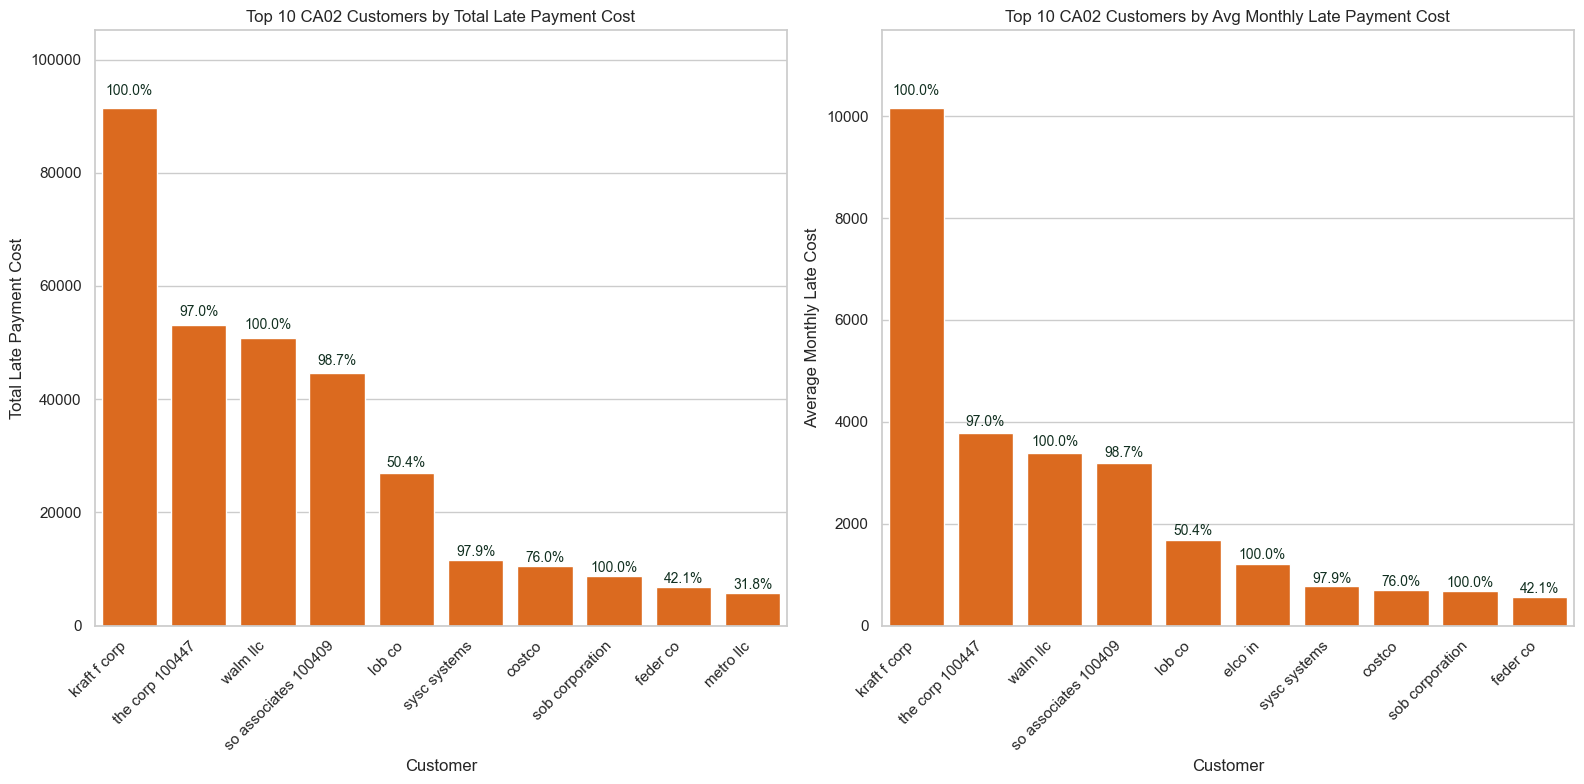

In [15]:

# CA02 customers
ca02_ids = closed_invoices.loc[closed_invoices["biz_CA02"] == 1, "customer_alt_id"].unique()
ca02 = customer_cost_stats[customer_cost_stats["customer_alt_id"].isin(ca02_ids)].copy()

if "pct_late_invoices" not in ca02.columns:
    ca02["pct_late_invoices"] = (
        ca02["late_invoices"] / ca02["n_invoices"] * 100
    )

top10_total_ca02 = ca02.sort_values("total_late_cost", ascending=False).head(10)
top10_monthly_ca02 = ca02.sort_values("avg_monthly_late_cost", ascending=False).head(10)

plt.figure(figsize=(16,8))

ax1 = plt.subplot(1, 2, 1)
sns.barplot(
    data=top10_total_ca02,
    x="customer_display_name",
    y="total_late_cost",
    color=tr_orange,
)
plt.title("Top 10 CA02 Customers by Total Late Payment Cost")
plt.ylabel("Total Late Payment Cost")
plt.xlabel("Customer")
plt.xticks(rotation=45, ha="right")
ax1.set_ylim(0, top10_total_ca02["total_late_cost"].max() * 1.15)
for bar, pct in zip(ax1.patches, top10_total_ca02["pct_late_invoices"]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax1.text(x, y * 1.02, f"{pct:.1f}%", ha="center", va="bottom", fontsize=10, color=tr_green)

ax2 = plt.subplot(1, 2, 2)
sns.barplot(
    data=top10_monthly_ca02,
    x="customer_display_name",
    y="avg_monthly_late_cost",
    color=tr_orange,
)
plt.title("Top 10 CA02 Customers by Avg Monthly Late Payment Cost")
plt.ylabel("Average Monthly Late Cost")
plt.xlabel("Customer")
plt.xticks(rotation=45, ha="right")
ax2.set_ylim(0, top10_monthly_ca02["avg_monthly_late_cost"].max() * 1.15)
for bar, pct in zip(ax2.patches, top10_monthly_ca02["pct_late_invoices"]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax2.text(x, y * 1.02, f"{pct:.1f}%", ha="center", va="bottom", fontsize=10, color=tr_green)

plt.tight_layout()
plt.show()


In [16]:

# Cost for delayed sending (invoice created but posted later)
creation_date = df[["document_create_date", "document_create_date.1"]].min(axis=1)

df["send_delay_days"] = (df["posting_date"] - creation_date).dt.days
df["send_delay_days"] = df["send_delay_days"].apply(lambda x: x if x > 1 else 0)

send_delay_mask = df["send_delay_days"] > 0

df["send_delay_cost"] = df["total_open_amount"] * daily_rate * df["send_delay_days"]

monthly_send_delay = (
    df.loc[send_delay_mask]
    .assign(send_delay_month=lambda x: x["posting_date"].dt.to_period("M"))
    .groupby("send_delay_month")["send_delay_cost"]
    .sum()
    .reset_index()
    .rename(columns={"send_delay_cost": "monthly_send_delay_cost"})
)

monthly_send_delay_count = (
    df.loc[send_delay_mask]
    .assign(send_delay_month=lambda x: x["posting_date"].dt.to_period("M"))
    .groupby("send_delay_month")["invoice_id"]
    .nunique()
    .reset_index(name="n_late_sent")
)

monthly_summary_send = monthly_send_delay.merge(
    monthly_send_delay_count,
    on="send_delay_month",
    how="left",
)
monthly_summary_send["send_delay_month_str"] = monthly_summary_send["send_delay_month"].astype(str)

percentiles = df.loc[send_delay_mask, "send_delay_cost"].quantile([0.50, 0.75, 0.90, 0.95])

print(f"Invoices with delayed sending (>1 day): {send_delay_mask.sum()} of {len(df)}")
print(f"Total cost of extended credit due to delayed sending: ${df.loc[send_delay_mask, 'send_delay_cost'].sum():,.2f}")
print(f"Median cost per invoice: ${df.loc[send_delay_mask, 'send_delay_cost'].median():,.2f}")
print("Percentiles (cost per invoice):")
for pct, value in percentiles.items():
    print(f"P{int(pct*100):>2}: ${value:,.2f}")


Invoices with delayed sending (>1 day): 10735 of 50000
Total cost of extended credit due to delayed sending: $208,174.90
Median cost per invoice: $11.92
Percentiles (cost per invoice):
P50: $11.92
P75: $26.10
P90: $45.24
P95: $62.06


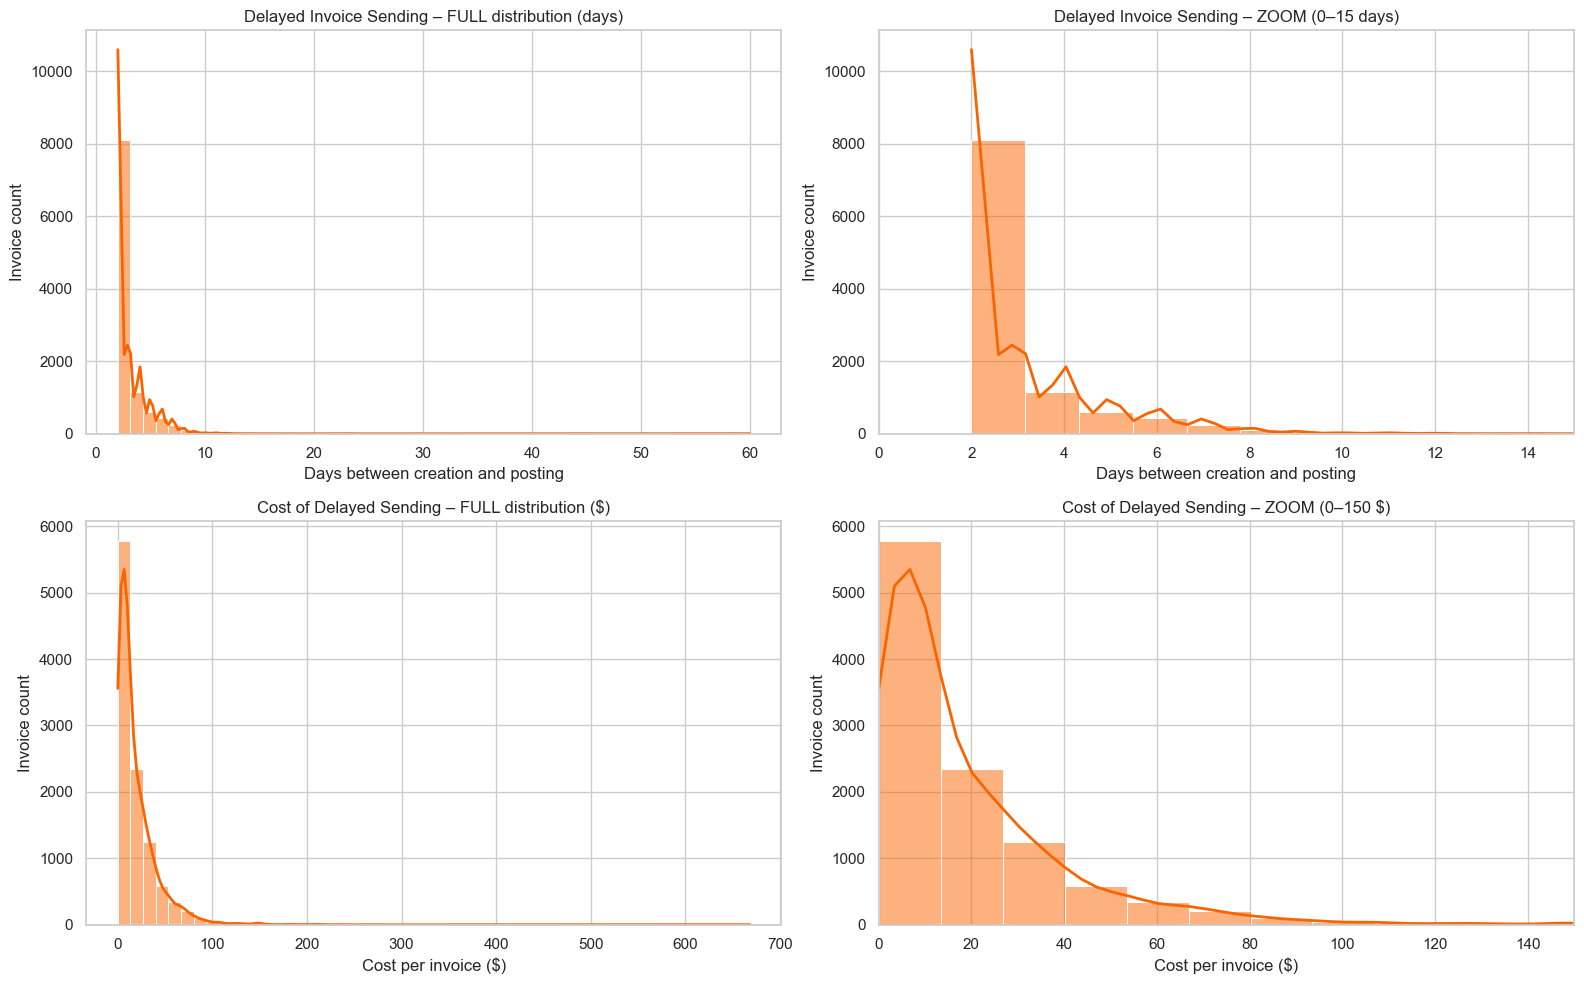

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# --- Full Send Delay (days) ---
sns.histplot(
    df.loc[send_delay_mask, "send_delay_days"],
    bins=50, kde=True,
    color=tr_orange,
    line_kws={"color": "tr_green", "linewidth": 2},
    ax=axes[0, 0]
)
axes[0, 0].set_title("Delayed Invoice Sending – FULL distribution (days)")
axes[0, 0].set_xlabel("Days between creation and posting")
axes[0, 0].set_ylabel("Invoice count")

# --- Zoom Send Delay (0–15 days) ---
sns.histplot(
    df.loc[send_delay_mask, "send_delay_days"],
    bins=50, kde=True,
    color=tr_orange,
    line_kws={"color": "tr_green", "linewidth": 2},
    ax=axes[0, 1]
)
axes[0, 1].set_xlim(0, 15)
axes[0, 1].set_title("Delayed Invoice Sending – ZOOM (0–15 days)")
axes[0, 1].set_xlabel("Days between creation and posting")
axes[0, 1].set_ylabel("Invoice count")

# --- Full Cost Distribution ---
sns.histplot(
    df.loc[send_delay_mask, "send_delay_cost"],
    bins=50, kde=True,
    color=tr_orange,
    line_kws={"color": "tr_green", "linewidth": 2},
    ax=axes[1, 0]
)
axes[1, 0].set_title("Cost of Delayed Sending – FULL distribution ($)")
axes[1, 0].set_xlabel("Cost per invoice ($)")
axes[1, 0].set_ylabel("Invoice count")

# --- Zoom Cost (0–150) ---
sns.histplot(
    df.loc[send_delay_mask, "send_delay_cost"],
    bins=50, kde=True,
    color=tr_orange,
    line_kws={"color": "tr_green", "linewidth": 2},
    ax=axes[1, 1]
)
axes[1, 1].set_xlim(0, 150)
axes[1, 1].set_title("Cost of Delayed Sending – ZOOM (0–150 $)")
axes[1, 1].set_xlabel("Cost per invoice ($)")
axes[1, 1].set_ylabel("Invoice count")

plt.tight_layout()
plt.show()


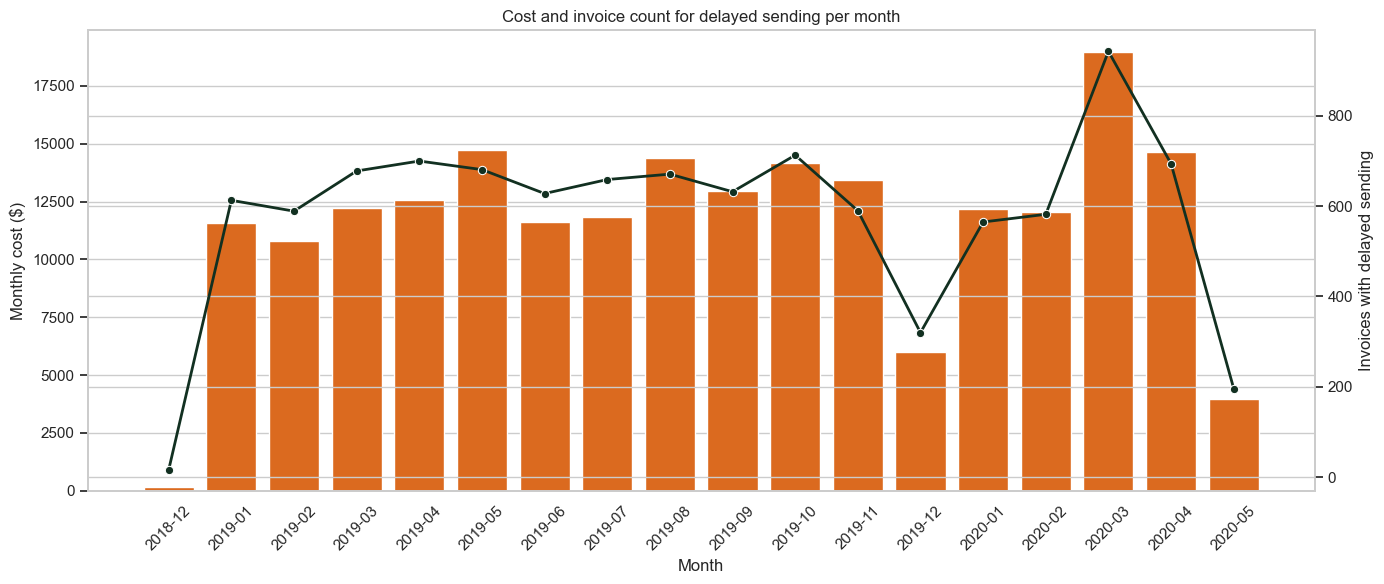

In [ ]:

fig, ax1 = plt.subplots(figsize=(14,6))

sns.barplot(
    data=monthly_summary_send,
    x="send_delay_month_str",
    y="monthly_send_delay_cost",
    ax=ax1,
    color=tr_orange,
)
ax1.set_ylabel("Monthly cost ($)")
ax1.set_xlabel("Month")
ax1.tick_params(axis='x', rotation=45)
ax1.ticklabel_format(style='plain', axis='y')

ax2 = ax1.twinx()
sns.lineplot(
    data=monthly_summary_send,
    x="send_delay_month_str",
    y="n_late_sent",
    ax=ax2,
    marker="o",
    color=tr_green,
    linewidth=2,
)
ax2.set_ylabel("Invoices with delayed sending")
ax2.ticklabel_format(style='plain', axis='y')

plt.title("Cost and invoice count for delayed sending per month")
plt.tight_layout()
plt.show()


In [ ]:

customer_send_delay = (
    df.loc[send_delay_mask]
    .groupby(["customer_alt_id", "customer_display_name"])
    .agg(
        total_send_cost=("send_delay_cost", "sum"),
        avg_send_cost=("send_delay_cost", "mean"),
        n_sent=("invoice_id", "nunique"),
        total_days=("send_delay_days", "sum"),
    )
    .sort_values("total_send_cost", ascending=False)
    .reset_index()
)

customer_send_delay.head(10)


,customer_alt_id,customer_display_name,total_send_cost,avg_send_cost,n_sent,total_days
0,100908,walmar trust,"37,828.2676",14.3724,2571,5956
1,100885,sa associates,"10,357.2854",20.6732,487,1194
2,100986,cost corporation,"7,446.3018",15.9450,447,1170
3,100891,cs wh systems,"5,948.3696",21.3203,270,637
4,100764,publi llc,"5,789.1023",51.2310,109,290
5,101095,kraft in,"5,627.1979",24.3602,224,672
6,100994,mcl corporation,"4,376.0475",27.3503,154,682
7,101098,kraft f corp,"4,158.3321",10.8857,377,1213
8,100761,king s associates,"3,803.7308",32.5105,113,280
9,100913,safew co,"3,558.9837",31.7766,110,247



## Correlations & Modeling


In [ ]:

# Weekday features and dummies
df_weekday = closed_invoices.copy()
df_weekday["due_weekday"] = df_weekday["due_in_date"].dt.weekday + 1
df_weekday["posting_weekday"] = df_weekday["posting_date"].dt.weekday + 1

due_weekday_dummies = pd.get_dummies(df_weekday["due_weekday"], prefix="due_wday")
posting_weekday_dummies = pd.get_dummies(df_weekday["posting_weekday"], prefix="post_wday")

if "document type" in df_weekday.columns:
    document_type_dummies = pd.get_dummies(df_weekday["document type"], prefix="doctype", dummy_na=False)
else:
    document_type_dummies = pd.DataFrame(index=df_weekday.index)

if "cust_payment_terms" in df_weekday.columns:
    payment_terms_dummies = pd.get_dummies(df_weekday["cust_payment_terms"], prefix="terms", dummy_na=False)
else:
    payment_terms_dummies = pd.DataFrame(index=df_weekday.index)

if "business_code" in df_weekday.columns:
    business_code_dummies = pd.get_dummies(df_weekday["business_code"], prefix="biz", dummy_na=False)
else:
    business_code_dummies = pd.DataFrame(index=df_weekday.index)

base_features_A = df_weekday[["is_late", "is_early", "amount", "grace_period"]]
feature_df_A = pd.concat(
    [
        base_features_A,
        document_type_dummies,
        payment_terms_dummies,
        business_code_dummies,
        due_weekday_dummies,
        posting_weekday_dummies,
    ],
    axis=1,
)


In [ ]:

corr_matrix = feature_df_A.corr(numeric_only=True)

corr_with_late = corr_matrix["is_late"].sort_values(ascending=False)
corr_with_early = corr_matrix["is_early"].sort_values(ascending=False)

print("Correlation (Pearson):")
for feature, value in corr_with_late.items():
    print(f"{feature:30s}  {value:.4f}")


Correlation (Pearson):
is_late                         1.0000
due_wday_6                      0.2639
biz_CA02                        0.2427
terms_CA10                      0.2416
post_wday_5                     0.2204
terms_NAX2                      0.1799
terms_NAG2                      0.1072
terms_NA10                      0.0681
terms_NAM1                      0.0647
due_wday_7                      0.0557
terms_NAD5                      0.0554
terms_NAVF                      0.0547
biz_U002                        0.0460
biz_U013                        0.0423
terms_NACB                      0.0364
post_wday_6                     0.0340
terms_NAVQ                      0.0287
terms_NAD4                      0.0240
amount                          0.0239
due_wday_5                      0.0229
terms_NA32                      0.0207
terms_CAB1                      0.0202
biz_U005                        0.0193
terms_NAM3                      0.0187
doctype_X2                      0.0187
te

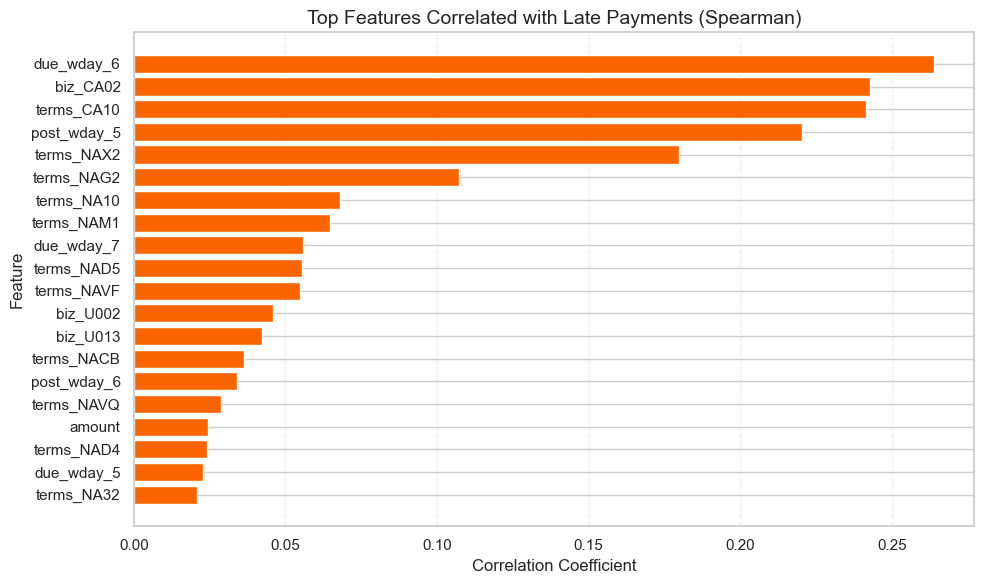

In [ ]:

# Spearman correlation – top features
spearman_corr = feature_df_A.corr(method="spearman", numeric_only=True)
spearman_late = spearman_corr["is_late"].sort_values(ascending=False)

top_late = spearman_late.drop(labels=["is_late"]).head(20)

plt.figure(figsize=(10,6))
plt.barh(y=top_late.index[::-1], width=top_late.values[::-1], color=tr_orange)
plt.title("Top Features Correlated with Late Payments (Spearman)", fontsize=14)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


posting_weekday
1   0.2301
2   0.2232
3   0.2229
4   0.3083
5   0.5263
6   0.3467
7   0.2124
Name: is_late, dtype: float64
due_weekday
1   0.2525
2   0.2039
3   0.1779
4   0.1822
5   0.3236
6   0.5781
7   0.3684
Name: is_late, dtype: float64


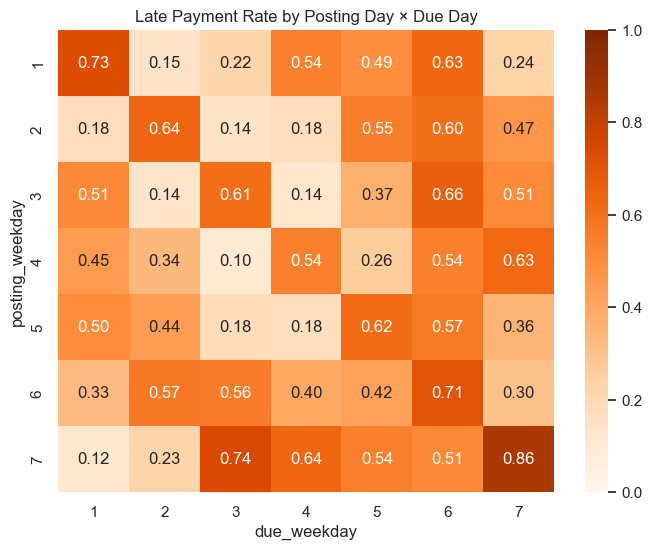

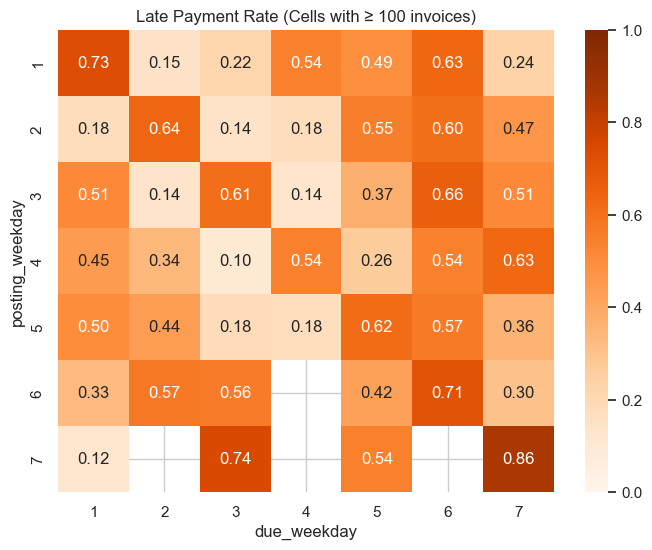

In [ ]:

print(df_weekday.groupby("posting_weekday")["is_late"].mean())
print(df_weekday.groupby("due_weekday")["is_late"].mean())

pivot = df_weekday.pivot_table(
    values="is_late",
    index="posting_weekday",
    columns="due_weekday",
    aggfunc="mean",
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, cmap="Oranges", annot=True, fmt=".2f", vmin=0, vmax=1)
plt.title("Late Payment Rate by Posting Day × Due Day")
plt.show()

counts = df_weekday.groupby(["posting_weekday", "due_weekday"]).size().unstack()
rates = df_weekday.groupby(["posting_weekday", "due_weekday"])["is_late"].mean().unstack()
mask = counts < 100

plt.figure(figsize=(8,6))
sns.heatmap(rates, mask=mask, cmap="Oranges", annot=True, fmt=".2f", vmin=0, vmax=1)
plt.title("Late Payment Rate (Cells with ≥ 100 invoices)")
plt.show()


Top 10 most common grace periods:


,count,pct
grace_period,,
15,29719,74.3000
20,1060,2.6500
10,933,2.3300
11,877,2.1900
35,685,1.7100
65,643,1.6100
0,635,1.5900
32,607,1.5200
30,525,1.3100


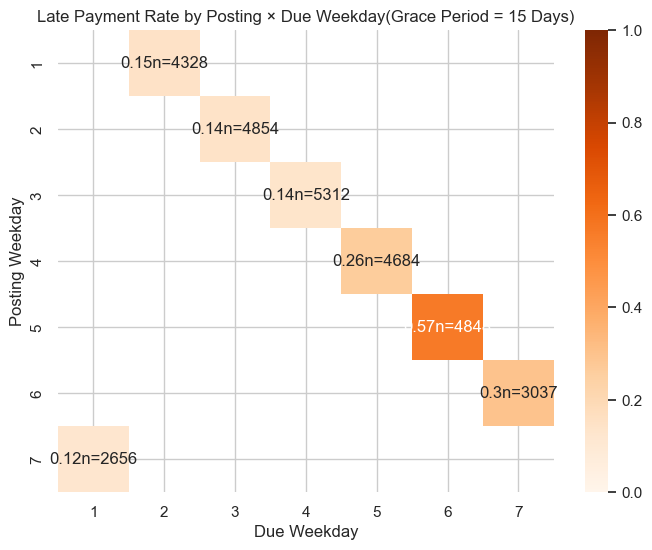

In [ ]:

# Grace period distribution
gp_counts = df_weekday["grace_period"].value_counts().sort_values(ascending=False)
gp_pct = (gp_counts / gp_counts.sum() * 100).round(2)
grace_summary = pd.DataFrame({"count": gp_counts, "pct": gp_pct}).head(10)
print("Top 10 most common grace periods:")
display(grace_summary)

gp15 = df_weekday[df_weekday["grace_period"] == 15].copy()
counts_15 = gp15.groupby(["posting_weekday", "due_weekday"]).size().unstack().fillna(0).astype(int)
rates_15 = gp15.groupby(["posting_weekday", "due_weekday"])["is_late"].mean().unstack()
annot = rates_15.round(2).astype(str) + "" + "n=" + counts_15.astype(str)

plt.figure(figsize=(8,6))
sns.heatmap(rates_15, cmap="Oranges", annot=annot, fmt="", vmin=0, vmax=1)
plt.title("Late Payment Rate by Posting × Due Weekday(Grace Period = 15 Days)")
plt.xlabel("Due Weekday")
plt.ylabel("Posting Weekday")
plt.show()


,customer_alt_id,customer_display_name,total_amount
58,100405,lob co,"44,573,682.6500"
62,100409,so associates 100409,"28,497,016.3900"
120,100469,walm llc,"21,853,164.2800"
59,100406,metro llc,"16,113,772.0800"
60,100407,costco,"10,714,953.2800"
87,100435,sysc systems,"8,449,147.5600"
92,100441,gordon f corporation,"5,502,782.6400"
48,100395,feder co,"5,183,572.7900"
49,100396,sob corporation,"4,908,338.6600"
45,100392,saveon co,"3,696,879.4900"


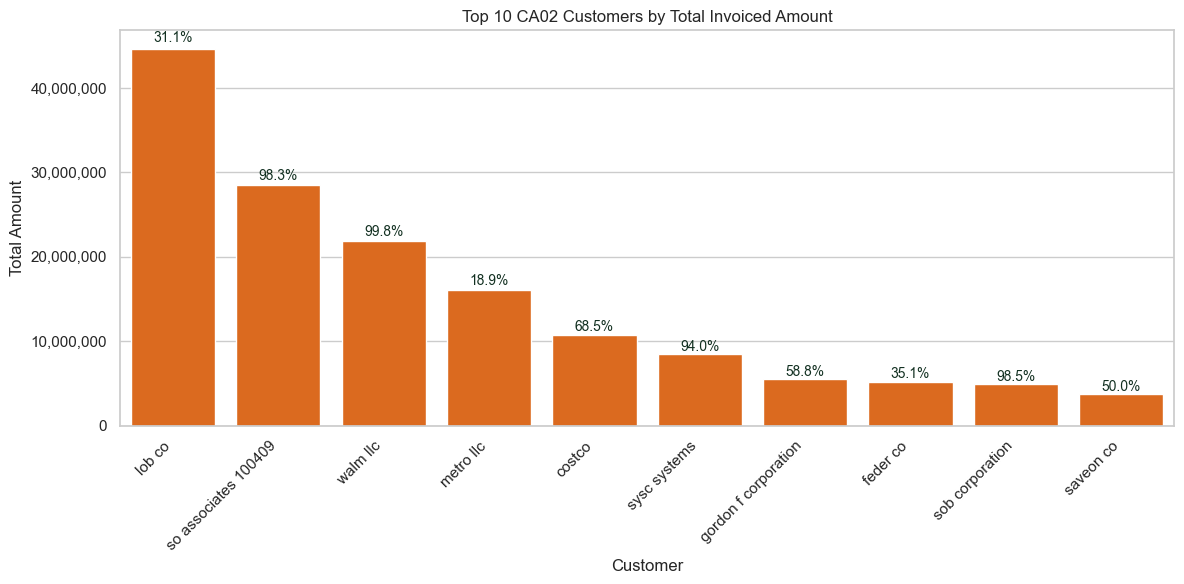

In [ ]:

# CA02 volume and lateness
ca02_subset = df_weekday[df_weekday["biz_CA02"] == 1].copy()
ca02_total_amount = (
    ca02_subset.groupby(["customer_alt_id", "customer_display_name"])["total_open_amount"]
    .sum()
    .reset_index(name="total_amount")
)

top10_ca02_amount = ca02_total_amount.sort_values("total_amount", ascending=False).head(10)
display(top10_ca02_amount)

ca02_mask = df_weekday["biz_CA02"] == 1
ca02_df = df_weekday[ca02_mask].copy()

amount_stats = (
    ca02_df.groupby(["customer_alt_id", "customer_display_name"])["total_open_amount"]
    .sum()
    .reset_index()
    .rename(columns={"total_open_amount": "total_amount"})
)
late_rate = (
    ca02_df.groupby("customer_alt_id")["is_late"]
    .mean()
    .mul(100)
    .reset_index(name="pct_late")
)
amount_stats = amount_stats.merge(late_rate, on="customer_alt_id")

top10_amount_ca02 = amount_stats.sort_values("total_amount", ascending=False).head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=top10_amount_ca02,
    x="customer_display_name",
    y="total_amount",
    color=tr_orange,
)
plt.title("Top 10 CA02 Customers by Total Invoiced Amount")
plt.xlabel("Customer")
plt.ylabel("Total Amount")
plt.xticks(rotation=45, ha="right")
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ",")))

for bar, pct in zip(ax.patches, top10_amount_ca02["pct_late"]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y * 1.01, f"{pct:.1f}%", ha="center", va="bottom", fontsize=10, color=tr_green)

plt.tight_layout()
plt.show()


Number of unique payment terms per customer:


unique_terms
1     829
2     105
3      84
4      25
5      11
6       1
11      1
Name: count, dtype: int64

Customers with >1 payment term: 227


customer_alt_id
100004    2
100011    2
100013    2
100019    2
100030    2
100040    2
100063    2
100068    2
100076    2
100085    2
100105    3
100112    2
100129    2
100132    4
100140    2
100183    2
100192    2
100202    2
100212    2
100267    2
Name: unique_terms, dtype: int64

,payment_term,lateness_rate,n_invoices,avg_grace_period,med_grace_period,lateness_rate_pct
69,NAX2,0.9982,548,0.2427,0.0000,99.8175
36,NAM1,0.6933,225,1.0267,1.0000,69.3333
5,CA10,0.6826,3069,13.1828,12.0000,68.2602
33,NAG2,0.6611,723,35.0609,35.0000,66.1134
60,NAVF,0.6533,199,45.0000,45.0000,65.3266
11,NA10,0.6210,372,10.0000,10.0000,62.0968
31,NAD5,0.6022,279,29.5018,30.0000,60.2151
14,NA32,0.3756,607,32.0000,32.0000,37.5618
59,NAVE,0.3196,219,30.2009,30.0000,31.9635
21,NAA8,0.3094,16016,14.9966,15.0000,30.9378


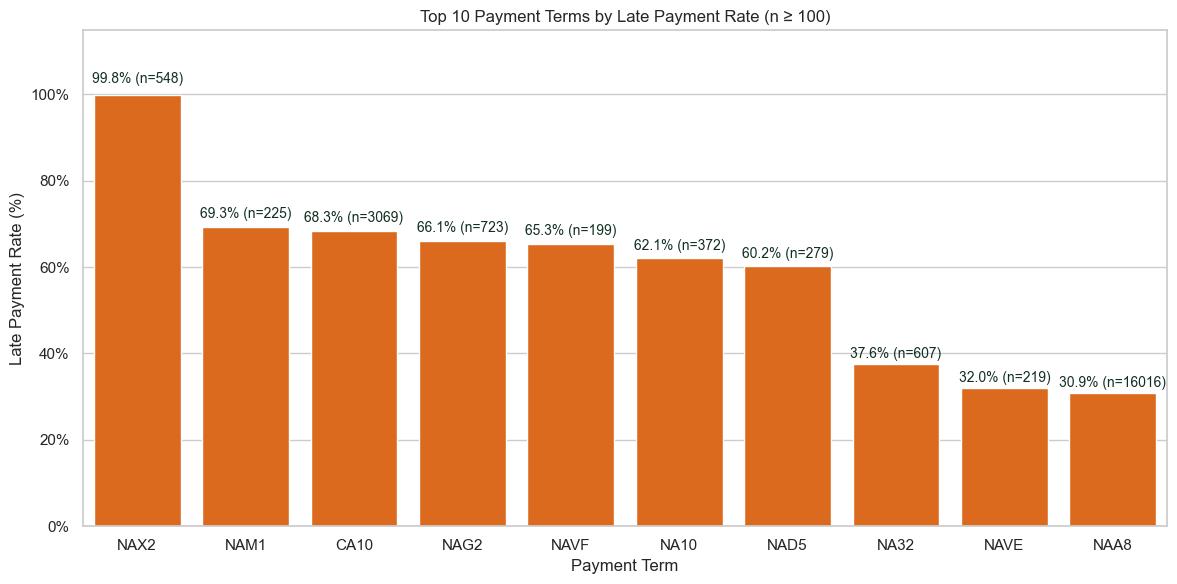

In [ ]:

# Payment terms: distribution and top terms
import matplotlib.ticker as mtick

terms_per_customer = (
    df_weekday.groupby("customer_alt_id")["cust_payment_terms"].nunique().rename("unique_terms")
)
terms_distribution = terms_per_customer.value_counts().sort_index()
print("Number of unique payment terms per customer:")
display(terms_distribution)

multi_term_customers = terms_per_customer[terms_per_customer > 1]
print(f"Customers with >1 payment term: {len(multi_term_customers)}")
display(multi_term_customers.head(20))

term_stats = (
    df_weekday
    .groupby("cust_payment_terms")
    .agg(
        lateness_rate=("is_late", "mean"),
        n_invoices=("invoice_id", "count"),
        avg_grace_period=("grace_period", "mean"),
        med_grace_period=("grace_period", "median"),
    )
    .reset_index()
    .rename(columns={"cust_payment_terms": "payment_term"})
)

term_stats["lateness_rate"] = pd.to_numeric(term_stats["lateness_rate"], errors="coerce")
term_stats["n_invoices"] = pd.to_numeric(term_stats["n_invoices"], errors="coerce").astype("Int64")
term_stats = term_stats.dropna(subset=["lateness_rate", "n_invoices"])

term_stats_filtered = term_stats[term_stats["n_invoices"] >= 100].copy()
term_stats_filtered["lateness_rate_pct"] = term_stats_filtered["lateness_rate"] * 100
term_stats_filtered = term_stats_filtered.sort_values("lateness_rate", ascending=False)

display(term_stats_filtered)

# Top 10 terms with most lateness
top10_terms = term_stats_filtered.head(10).copy()

if top10_terms.empty:
    print("No payment terms with at least 100 invoices to plot.")
else:
    top10_terms["lateness_rate"] = pd.to_numeric(top10_terms["lateness_rate"], errors="coerce")
    top10_terms["n_invoices"] = pd.to_numeric(top10_terms["n_invoices"], errors="coerce").fillna(0).astype(int)

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=top10_terms,
        x="payment_term",
        y="lateness_rate",
        color=tr_orange,
    )
    plt.title("Top 10 Payment Terms by Late Payment Rate (n ≥ 100)")
    plt.xlabel("Payment Term")
    plt.ylabel("Late Payment Rate (%)")
    ax.set_ylim(0, top10_terms["lateness_rate"].max() * 1.15)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    for bar, (rate, n) in zip(ax.patches, zip(top10_terms["lateness_rate"], top10_terms["n_invoices"])):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        ax.text(x, y * 1.02, f"{float(rate)*100:.1f}% (n={int(n)})", ha="center", va="bottom", fontsize=10, color=tr_green)

    plt.tight_layout()
    plt.show()


In [ ]:

# Clustering of payment terms
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

term_stats_cluster = term_stats_filtered.copy()
term_stats_cluster["log_n"] = np.log10(term_stats_cluster["n_invoices"])

X = term_stats_cluster[["lateness_rate", "avg_grace_period", "log_n"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)
term_stats_cluster["cluster"] = labels

df_terms = term_stats_cluster.copy()
df_terms = df_terms.sort_values("lateness_rate", ascending=False)

cluster_palette = {0: "#123021", 1: "#F5A623", 2: "#D0021B"}


lateness_rate        float64
avg_grace_period     float64
invoice_count_log    Float64
dtype: object
float64


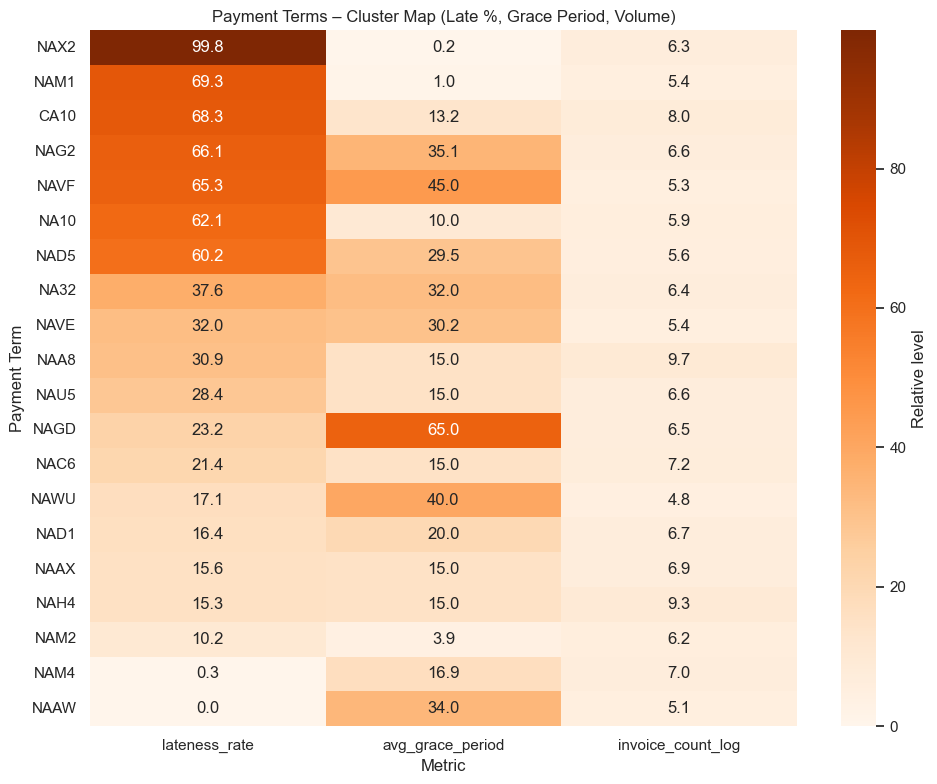

In [ ]:
# Build cluster_map_df
cluster_map_df = df_terms.set_index("payment_term")[[
    "lateness_rate", "avg_grace_period", "n_invoices"
]].copy()

cluster_map_df["lateness_rate"] = cluster_map_df["lateness_rate"] * 100
cluster_map_df["invoice_count_log"] = np.log1p(cluster_map_df["n_invoices"])

# --- strictly select only the 3 numeric columns you want ---
# With log
heat_data = cluster_map_df[["lateness_rate", "avg_grace_period", "invoice_count_log"]].copy()
cluster_map_df["invoice_count_log"] = np.log1p(cluster_map_df["n_invoices"])

# Without Log
# heat_data = cluster_map_df[["lateness_rate", "avg_grace_period", "n_invoices"]].copy()

# Force to numeric and to a pure float matrix
heat_data = heat_data.apply(pd.to_numeric, errors="raise")  # will blow up if anything non-numeric
heat_array = heat_data.to_numpy(dtype=float)

print(heat_data.dtypes)              # should all be float64
print(heat_array.dtype)              # should be float64

plt.figure(figsize=(10, max(6, 0.4 * len(heat_data))))
sns.heatmap(
    heat_array,
    annot=True,
    fmt=".1f",
    cmap="Oranges",
    cbar_kws={"label": "Relative level"},
    xticklabels=heat_data.columns,    # "lateness_rate", "avg_grace_period", "invoice_count_log"
    yticklabels=heat_data.index,      # payment_term labels
)
plt.title("Payment Terms – Cluster Map (Late %, Grace Period, Volume)")
plt.xlabel("Metric")
plt.ylabel("Payment Term")
plt.tight_layout()
plt.show()


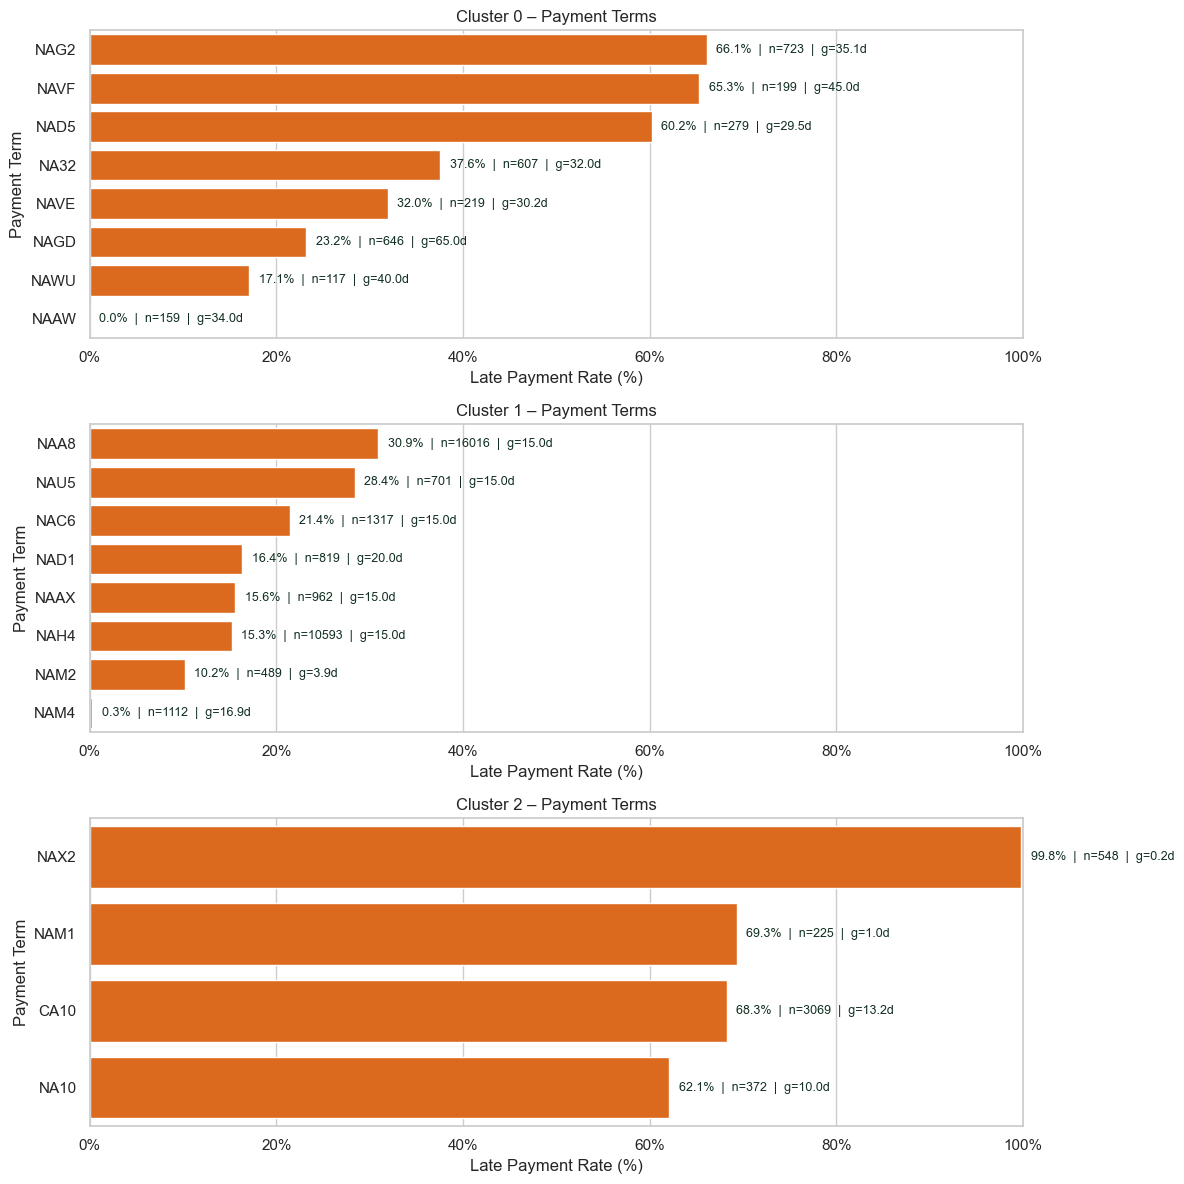

In [ ]:
clusters = sorted(df_terms["cluster"].unique())
n_clusters = len(clusters)
fig, axes = plt.subplots(n_clusters, 1, figsize=(12, 4 * n_clusters), sharex=False)
if n_clusters == 1:
    axes = [axes]

for ax, cl in zip(axes, clusters):
    sub = df_terms[df_terms["cluster"] == cl].copy()
    sub = sub.sort_values("lateness_rate", ascending=False)
    sns.barplot(data=sub, x="lateness_rate", y="payment_term", color=tr_orange, ax=ax)
    ax.set_xlim(0, 1)
    ax.set_xticks(np.linspace(0, 1, 6))
    ax.set_xticklabels([f"{x*100:.0f}%" for x in ax.get_xticks()])
    ax.set_xlabel("Late Payment Rate (%)")
    ax.set_ylabel("Payment Term")
    ax.set_title(f"Cluster {cl} – Payment Terms")
    for i, row in sub.iterrows():
        ax.text(
            row["lateness_rate"] + 0.01,
            sub.index.get_loc(i),
            f"{row['lateness_rate']*100:.1f}%  |  n={int(row['n_invoices'])}  |  g={row['avg_grace_period']:.1f}d",
            va="center",
            fontsize=9,
            color=tr_green,
        )

plt.tight_layout()
plt.show()


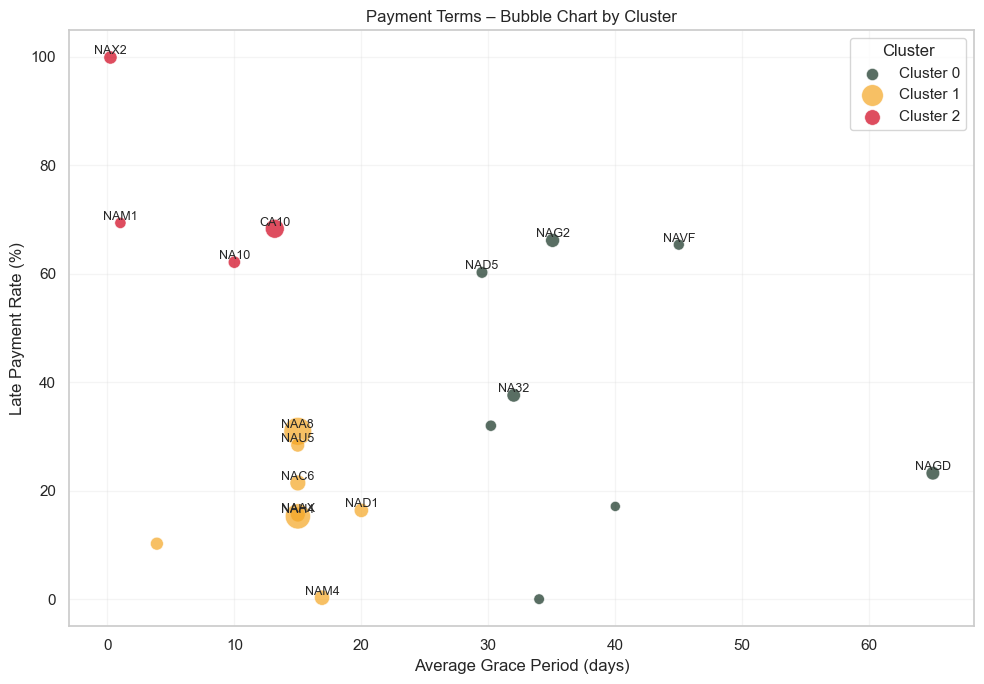

In [ ]:

plt.figure(figsize=(10, 7))
for cl, group in df_terms.groupby("cluster"):
    plt.scatter(
        group["avg_grace_period"],
        group["lateness_rate"] * 100,
        s=20 + 3 * np.sqrt(group["n_invoices"]),
        color=cluster_palette.get(cl, "grey"),
        alpha=0.7,
        label=f"Cluster {cl}",
        edgecolors="white",
        linewidths=0.5,
    )

label_mask = (df_terms["n_invoices"] >= 500) | (df_terms["lateness_rate"] >= 0.5)
for _, row in df_terms[label_mask].iterrows():
    plt.text(row["avg_grace_period"], row["lateness_rate"] * 100, row["payment_term"], fontsize=9, ha="center", va="bottom")

plt.xlabel("Average Grace Period (days)")
plt.ylabel("Late Payment Rate (%)")
plt.title("Payment Terms – Bubble Chart by Cluster")
plt.grid(alpha=0.2)
plt.legend(title="Cluster", loc="upper right")
plt.tight_layout()
plt.show()


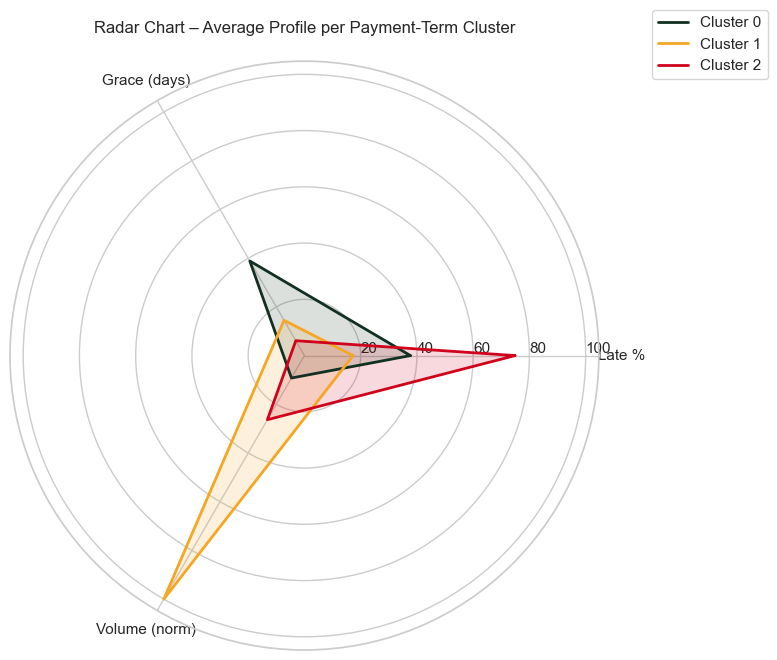

In [ ]:

from math import pi

cluster_summary = (
    df_terms
    .groupby("cluster")
    .agg(
        lateness_rate=("lateness_rate", "mean"),
        avg_grace_period=("avg_grace_period", "mean"),
        volume=("n_invoices", "mean"),
    )
)
cluster_summary["lateness_rate"] *= 100
cluster_summary["volume_norm"] = cluster_summary["volume"] / cluster_summary["volume"].max() * 100

metrics = ["lateness_rate", "avg_grace_period", "volume_norm"]
labels = ["Late %", "Grace (days)", "Volume (norm)"]
N = len(metrics)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
for cl, row in cluster_summary.iterrows():
    values = [row[m] for m in metrics]
    values += values[:1]
    ax.plot(angles, values, color=cluster_palette.get(cl, "grey"), linewidth=2, label=f"Cluster {cl}")
    ax.fill(angles, values, color=cluster_palette.get(cl, "grey"), alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_rlabel_position(0)
ax.set_title("Radar Chart – Average Profile per Payment-Term Cluster", pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


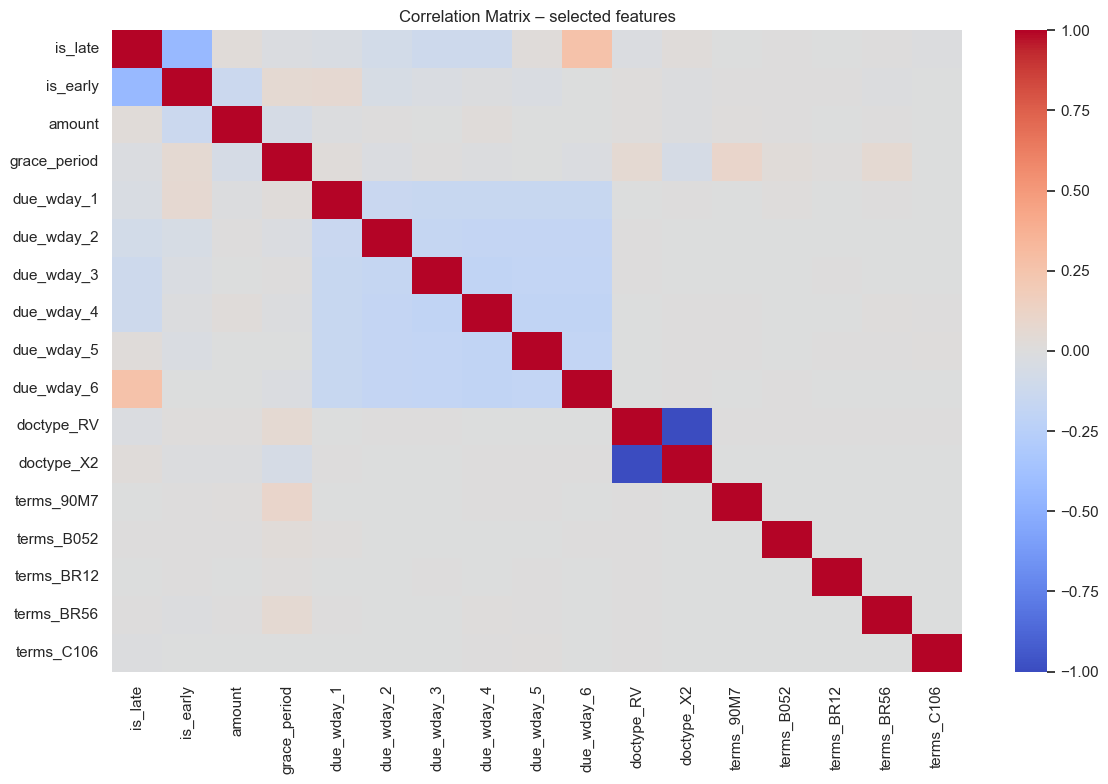

In [ ]:

# Correlation matrix – selected features
base_cols = ["is_late", "is_early", "amount", "grace_period"]
weekday_cols = [c for c in feature_df_A.columns if c.startswith("due_wday_") or c.startswith("post_wday_")][:6]
doc_cols = list(document_type_dummies.columns[:5])
term_cols = list(payment_terms_dummies.columns[:5])
cols_for_heatmap = [c for c in base_cols + weekday_cols + doc_cols + term_cols if c in feature_df_A.columns]

corr_subset = feature_df_A[cols_for_heatmap].corr()
plt.figure(figsize=(max(12, 0.7*len(cols_for_heatmap)), 8))
sns.heatmap(corr_subset, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix – selected features")
plt.tight_layout()
plt.show()


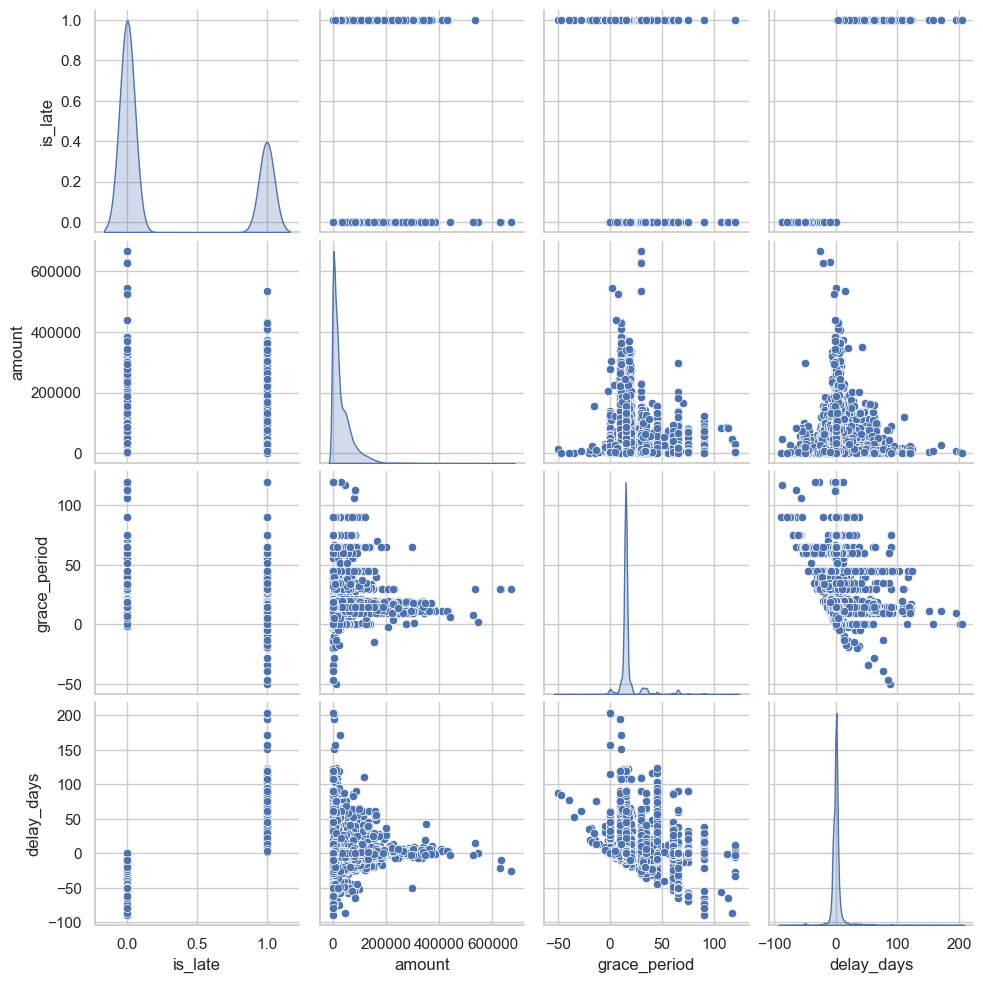

In [ ]:

# Correlation Pairplot (selected features)
sns.pairplot(df_weekday[["is_late", "amount", "grace_period", "delay_days"]], diag_kind="kde")
plt.show()


In [ ]:

# Correlation table filtered by threshold
threshold = 0.1
corr_tbl = corr_with_late[abs(corr_with_late) > threshold]
corr_tbl


is_late        1.0000
due_wday_6     0.2639
biz_CA02       0.2427
terms_CA10     0.2416
post_wday_5    0.2204
terms_NAX2     0.1799
terms_NAG2     0.1072
terms_NAM4    -0.1095
due_wday_3    -0.1119
due_wday_4    -0.1136
terms_NAH4    -0.1923
biz_U001      -0.2495
is_early      -0.4323
Name: is_late, dtype: float64

In [ ]:

# Customer history features (non-causal)
customer_stats = (
    df_weekday
    .groupby("customer_alt_id")
    .agg(
        cust_total_invoices=("invoice_id", "nunique"),
        cust_late_rate=("is_late", "mean"),
        cust_avg_delay=("delay_days", "mean"),
        cust_median_delay=("delay_days", "median"),
        cust_total_amount=("amount", "sum"),
        cust_avg_amount=("amount", "mean"),
        cust_avg_grace_period=("grace_period", "mean"),
    )
    .reset_index()
)

closed_invoices_hist = df_weekday.merge(customer_stats, on="customer_alt_id", how="left")
customer_feature_cols = [
    "cust_total_invoices",
    "cust_late_rate",
    "cust_avg_delay",
    "cust_median_delay",
    "cust_total_amount",
    "cust_avg_amount",
    "cust_avg_grace_period",
]

base_features_B = closed_invoices_hist[["is_late", "is_early", "amount", "grace_period"] + customer_feature_cols]
feature_df_B = pd.concat(
    [
        base_features_B,
        document_type_dummies,
        payment_terms_dummies,
        business_code_dummies,
        due_weekday_dummies,
        posting_weekday_dummies,
    ],
    axis=1,
)


In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

# Model A – invoice only
X_A = feature_df_A.drop(columns=["is_late", "is_early"])
y_A = feature_df_A["is_late"]
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.3, random_state=42, stratify=y_A)
model_A = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
model_A.fit(X_train_A, y_train_A)
y_pred_A = model_A.predict(X_test_A)
y_proba_A = model_A.predict_proba(X_test_A)[:, 1]

# Model B – invoice plus history
b_clean = feature_df_B[feature_df_B["is_late"].notna()].copy()
X_B = b_clean.drop(columns=["is_late", "is_early"])
y_B = b_clean["is_late"].astype(int)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.3, random_state=42, stratify=y_B)
model_B = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
model_B.fit(X_train_B, y_train_B)
y_pred_B = model_B.predict(X_test_B)
y_proba_B = model_B.predict_proba(X_test_B)[:, 1]


=== Model A ===
Accuracy:        0.7344
Precision:       0.5577
Recall:          0.5439
F1-score:        0.5507
ROC-AUC:         0.7622


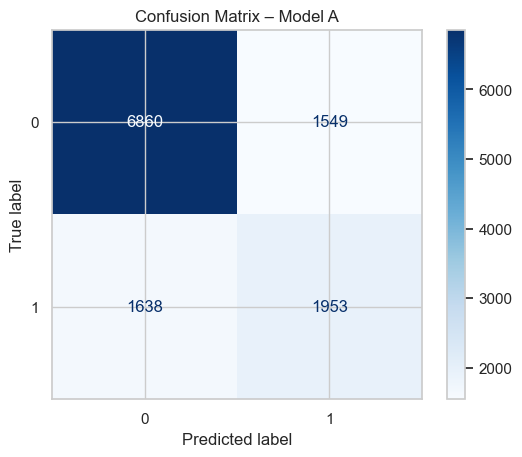

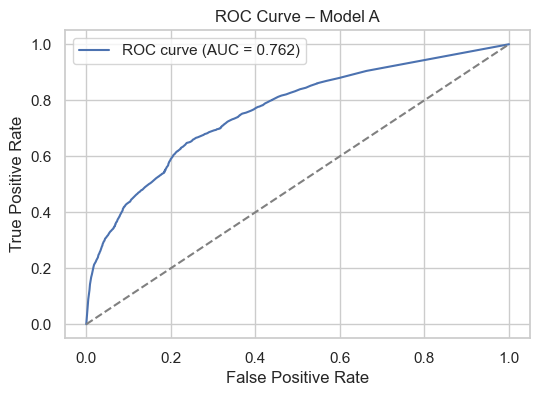

In [ ]:

# Model performance
acc = accuracy_score(y_test_A, y_pred_A)
prec = precision_score(y_test_A, y_pred_A)
rec = recall_score(y_test_A, y_pred_A)
f1 = f1_score(y_test_A, y_pred_A)
auc = roc_auc_score(y_test_A, y_proba_A)

print("=== Model A ===")
print(f"Accuracy:        {acc:.4f}")
print(f"Precision:       {prec:.4f}")
print(f"Recall:          {rec:.4f}")
print(f"F1-score:        {f1:.4f}")
print(f"ROC-AUC:         {auc:.4f}")

cm = confusion_matrix(y_test_A, y_pred_A)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Model A")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test_A, y_proba_A)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Model A")
plt.legend()
plt.show()


In [ ]:

# Optimal threshold (Youden's J)
fpr, tpr, thresholds = roc_curve(y_test_A, y_proba_A)
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}")
print(f"Sensitivity (TPR): {tpr[optimal_idx]:.4f}")
print(f"Specificity (1-FPR): {1 - fpr[optimal_idx]:.4f}")

y_pred_opt = (y_proba_A >= optimal_threshold).astype(int)
acc_opt = accuracy_score(y_test_A, y_pred_opt)
prec_opt = precision_score(y_test_A, y_pred_opt)
rec_opt = recall_score(y_test_A, y_pred_opt)
f1_opt = f1_score(y_test_A, y_pred_opt)

print("=== Performance at optimal threshold ===")
print(f"Accuracy:  {acc_opt:.4f}")
print(f"Precision: {prec_opt:.4f}")
print(f"Recall:    {rec_opt:.4f}")
print(f"F1-score:  {f1_opt:.4f}")


Optimal threshold (Youden's J): 0.2733
Sensitivity (TPR): 0.6477
Specificity (1-FPR): 0.7620
=== Performance at optimal threshold ===
Accuracy:  0.7278
Precision: 0.5376
Recall:    0.6477
F1-score:  0.5875


In [ ]:

# Compare models side by side
def evaluate_model(name, y_test, y_pred, y_proba):
    print(f"=== {name} ===")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}")

evaluate_model("Model A – Invoice only", y_test_A, y_pred_A, y_proba_A)
evaluate_model("Model B – Invoice + Customer history", y_test_B, y_pred_B, y_proba_B)


=== Model A – Invoice only ===
Accuracy:  0.7344
Precision: 0.5577
Recall:    0.5439
F1-score:  0.5507
ROC-AUC:   0.7622
=== Model B – Invoice + Customer history ===
Accuracy:  0.7397
Precision: 0.5730
Recall:    0.5102
F1-score:  0.5398
ROC-AUC:   0.7654


In [ ]:

# Model B with causal (lagged) customer history
closed_sorted = df_weekday.sort_values(["customer_alt_id", "posting_date"]).copy()

closed_sorted["cust_total_invoices_lag"] = closed_sorted.groupby("customer_alt_id").cumcount()
closed_sorted["cust_late_rate_lag"] = closed_sorted.groupby("customer_alt_id")["is_late"].apply(lambda x: x.shift().expanding().mean())
closed_sorted["cust_avg_delay_lag"] = closed_sorted.groupby("customer_alt_id")["delay_days"].apply(lambda x: x.shift().expanding().mean())
closed_sorted["cust_median_delay_lag"] = closed_sorted.groupby("customer_alt_id")["delay_days"].apply(lambda x: x.shift().expanding().median())
closed_sorted["cust_avg_grace_period_lag"] = closed_sorted.groupby("customer_alt_id")["grace_period"].apply(lambda x: x.shift().expanding().mean())

customer_feature_cols_lag = [
    "cust_total_invoices_lag",
    "cust_late_rate_lag",
    "cust_avg_delay_lag",
    "cust_median_delay_lag",
    "cust_avg_grace_period_lag",
]

base_features_B_lag = closed_sorted[["is_late", "is_early", "amount", "grace_period"] + customer_feature_cols_lag]
feature_df_B_lag = pd.concat(
    [
        base_features_B_lag,
        document_type_dummies.reindex(closed_sorted.index),
        payment_terms_dummies.reindex(closed_sorted.index),
        business_code_dummies.reindex(closed_sorted.index),
        due_weekday_dummies.reindex(closed_sorted.index),
        posting_weekday_dummies.reindex(closed_sorted.index),
    ],
    axis=1,
)

cols_must_have = ["is_late"] + customer_feature_cols_lag
feature_df_B_clean = feature_df_B_lag.dropna(subset=cols_must_have).copy()
print("Rows before cleaning:", len(feature_df_B_lag))
print("Rows after cleaning:", len(feature_df_B_clean))

X_B2 = feature_df_B_clean.drop(columns=["is_late", "is_early"])
y_B2 = feature_df_B_clean["is_late"].astype(int)
X_train_B2, X_test_B2, y_train_B2, y_test_B2 = train_test_split(X_B2, y_B2, test_size=0.3, random_state=42, stratify=y_B2)
model_B2 = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
model_B2.fit(X_train_B2, y_train_B2)
y_pred_B2 = model_B2.predict(X_test_B2)
y_proba_B2 = model_B2.predict_proba(X_test_B2)[:, 1]

print("=== Model B – Invoice + Causal customer history (lagged features) ===")
print(f"Accuracy:  {accuracy_score(y_test_B2, y_pred_B2):.4f}")
print(f"Precision: {precision_score(y_test_B2, y_pred_B2):.4f}")
print(f"Recall:    {recall_score(y_test_B2, y_pred_B2):.4f}")
print(f"F1-score:  {f1_score(y_test_B2, y_pred_B2):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test_B2, y_proba_B2):.4f}")


TypeError: incompatible index of inserted column with frame index